In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import sys; sys.path.insert(0, "../../")

import os
import logging
from functools import partial
from itertools import combinations

import numpy as np
import jax
from jax import random
from jax import numpy as jnp
from flax.training.checkpoints import save_checkpoint, restore_checkpoint
import distrax
import wandb
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import src.models as models
from src.models import make_PoG_Ens_loss, make_Reg_Ens_loss, make_PoN_Ens_loss
from src.models import make_PoG_Ens_plots, make_Reg_Ens_plots, make_PoN_Ens_plots
import src.data
from src.data import NumpyLoader
from src.utils.training import setup_training, train_loop
from experiments.configs.comparison_figures_pog import get_config as get_pog_config
from experiments.configs.comparison_figures_reg_ens import get_config as get_reg_ens_config
from experiments.configs.comparison_figures_pon import get_config as get_pon_config
from src.models.pog import calculate_pog_loc_scale
from src.models.reg_ens import calculate_ens_loc_scale
from src.models.pon import normal_prod
from src.models.common import MembersLL
from src.utils.notebook_metrics_regression import *

In [32]:
os.environ['XLA_FLAGS'] = "--xla_gpu_force_compilation_parallelism=1"

In [45]:
POG_RETRAIN = True
ENS_RETRAIN = True

In [34]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'regression_performance_gap_investigation.ipynb'
# ^ W&B doesn't know how to handle VS Code notebooks.

wandb.login()

True

In [86]:
config = get_pog_config()

data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size)
val_loader = NumpyLoader(val_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, config.batch_size)

init_x = train_dataset[0][0]
init_y = train_dataset[0][1]

## 1. PoG training

In [87]:
MEMBERS_LL = MembersLL.GND
# MEMBERS_LL = MembersLL.gaussian
# BETA_END = [2, 8 ,16]
# ALPHAS = [0., 0.5, 1.]
BETA_END = [16]
ALPHAS = [0.5]

In [88]:
config = get_pog_config()

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

2022-10-20 17:33:09.696953: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-20 17:33:10.319723: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-20 17:33:10.319789: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-20 17:33:10.319796: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


  0%|          | 0/201 [00:00<?, ?it/s]

epoch:   1 - ('train loss: 1.93709, val loss: 1.97307, train err:    nan, val err:    nan, β: 2.0937, lr: 0.00010, prod_nll: 1.25899', ', members_nll: 2.61518')
epoch:   2 - ('train loss: 1.85019, val loss: 1.98779, train err:    nan, val err:    nan, β: 2.0984, lr: 0.00010, prod_nll: 1.17311', ', members_nll: 2.52726')
epoch:   3 - ('train loss: 1.82239, val loss: 1.99996, train err:    nan, val err:    nan, β: 2.1034, lr: 0.00010, prod_nll: 1.15194', ', members_nll: 2.49283')
epoch:   4 - ('train loss: 1.77950, val loss: 2.00955, train err:    nan, val err:    nan, β: 2.1087, lr: 0.00010, prod_nll: 1.12246', ', members_nll: 2.43654')
epoch:   5 - ('train loss: 1.73417, val loss: 2.01660, train err:    nan, val err:    nan, β: 2.1142, lr: 0.00010, prod_nll: 1.09111', ', members_nll: 2.37722')
epoch:   6 - ('train loss: 1.69514, val loss: 2.02092, train err:    nan, val err:    nan, β: 2.1199, lr: 0.00010, prod_nll: 1.06207', ', members_nll: 2.32821')
epoch:   7 - ('train loss: 1.65360

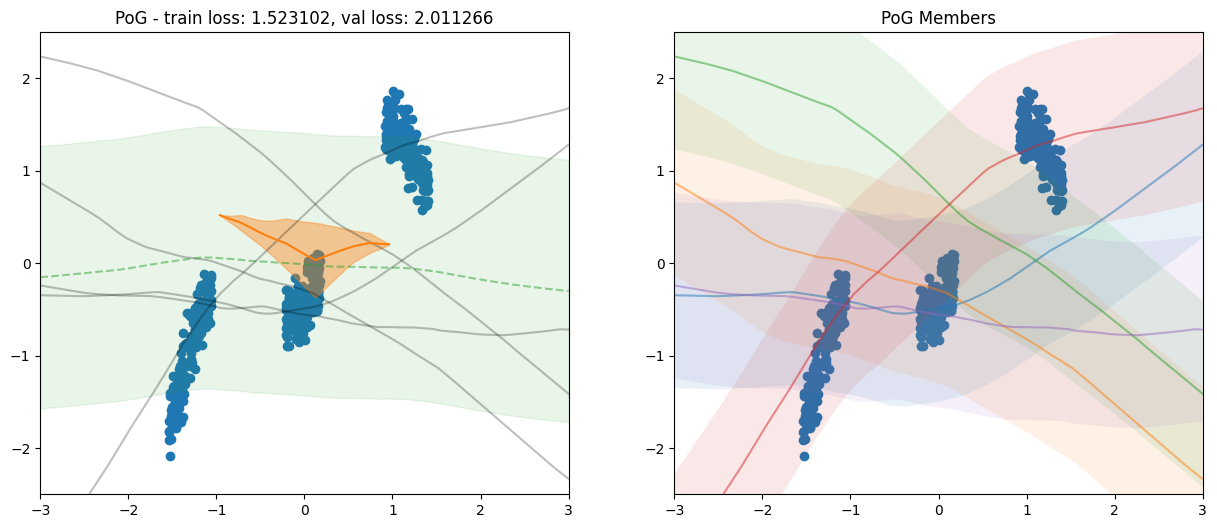

epoch:  11 - ('train loss: 1.47847, val loss: 2.00289, train err:    nan, val err:    nan, β: 2.1534, lr: 0.00010, prod_nll: 0.90566', ', members_nll: 2.05128')
epoch:  12 - ('train loss: 1.43107, val loss: 1.99258, train err:    nan, val err:    nan, β: 2.1612, lr: 0.00010, prod_nll: 0.87437', ', members_nll: 1.98777')
epoch:  13 - ('train loss: 1.39055, val loss: 1.98030, train err:    nan, val err:    nan, β: 2.1693, lr: 0.00010, prod_nll: 0.84658', ', members_nll: 1.93453')
epoch:  14 - ('train loss: 1.35593, val loss: 1.96583, train err:    nan, val err:    nan, β: 2.1778, lr: 0.00010, prod_nll: 0.82203', ', members_nll: 1.88983')
epoch:  15 - ('train loss: 1.31330, val loss: 1.95022, train err:    nan, val err:    nan, β: 2.1868, lr: 0.00010, prod_nll: 0.79410', ', members_nll: 1.83250')
epoch:  16 - ('train loss: 1.27717, val loss: 1.93331, train err:    nan, val err:    nan, β: 2.1962, lr: 0.00010, prod_nll: 0.77004', ', members_nll: 1.78430')
epoch:  17 - ('train loss: 1.24290

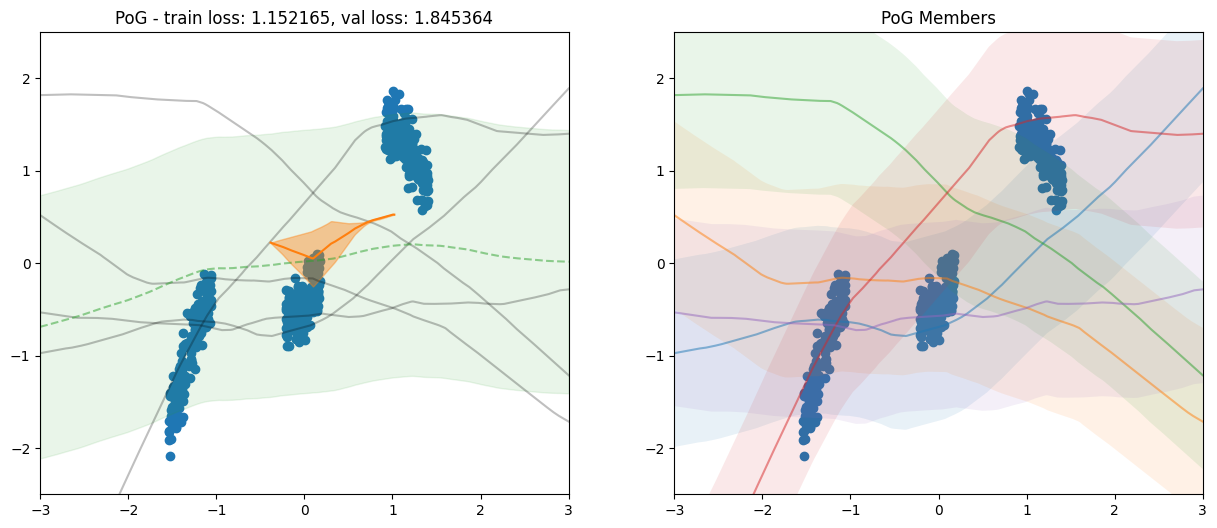

epoch:  21 - ('train loss: 1.12559, val loss: 1.81923, train err:    nan, val err:    nan, β: 2.2506, lr: 0.00010, prod_nll: 0.67565', ', members_nll: 1.57553')
epoch:  22 - ('train loss: 1.10065, val loss: 1.79220, train err:    nan, val err:    nan, β: 2.2631, lr: 0.00010, prod_nll: 0.66078', ', members_nll: 1.54053')
epoch:  23 - ('train loss: 1.07702, val loss: 1.76437, train err:    nan, val err:    nan, β: 2.2763, lr: 0.00010, prod_nll: 0.64675', ', members_nll: 1.50728')
epoch:  24 - ('train loss: 1.05358, val loss: 1.73587, train err:    nan, val err:    nan, β: 2.2901, lr: 0.00010, prod_nll: 0.63329', ', members_nll: 1.47388')
epoch:  25 - ('train loss: 1.03280, val loss: 1.70691, train err:    nan, val err:    nan, β: 2.3046, lr: 0.00010, prod_nll: 0.62237', ', members_nll: 1.44323')
epoch:  26 - ('train loss: 1.01380, val loss: 1.67771, train err:    nan, val err:    nan, β: 2.3197, lr: 0.00010, prod_nll: 0.61098', ', members_nll: 1.41663')
epoch:  27 - ('train loss: 0.99700

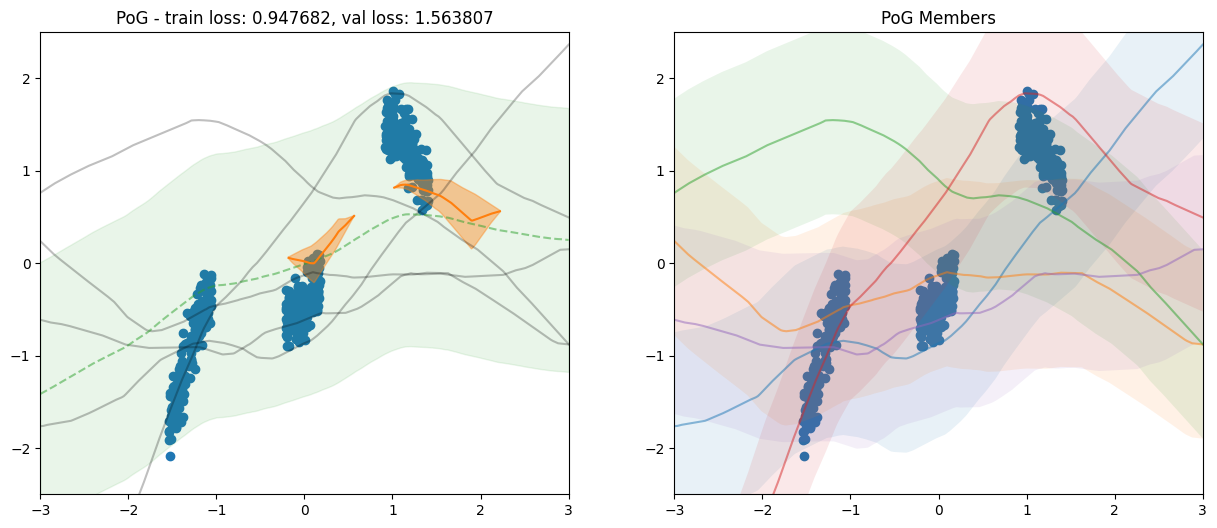

epoch:  31 - ('train loss: 0.93303, val loss: 1.53678, train err:    nan, val err:    nan, β: 2.4074, lr: 0.00010, prod_nll: 0.56450', ', members_nll: 1.30156')
epoch:  32 - ('train loss: 0.91914, val loss: 1.51050, train err:    nan, val err:    nan, β: 2.4276, lr: 0.00010, prod_nll: 0.55558', ', members_nll: 1.28271')
epoch:  33 - ('train loss: 0.90592, val loss: 1.48537, train err:    nan, val err:    nan, β: 2.4487, lr: 0.00010, prod_nll: 0.54686', ', members_nll: 1.26499')
epoch:  34 - ('train loss: 0.89328, val loss: 1.46136, train err:    nan, val err:    nan, β: 2.4708, lr: 0.00010, prod_nll: 0.53827', ', members_nll: 1.24828')
epoch:  35 - ('train loss: 0.88110, val loss: 1.43829, train err:    nan, val err:    nan, β: 2.4940, lr: 0.00010, prod_nll: 0.52974', ', members_nll: 1.23246')
epoch:  36 - ('train loss: 0.86934, val loss: 1.41621, train err:    nan, val err:    nan, β: 2.5182, lr: 0.00010, prod_nll: 0.52125', ', members_nll: 1.21743')
epoch:  37 - ('train loss: 0.85792

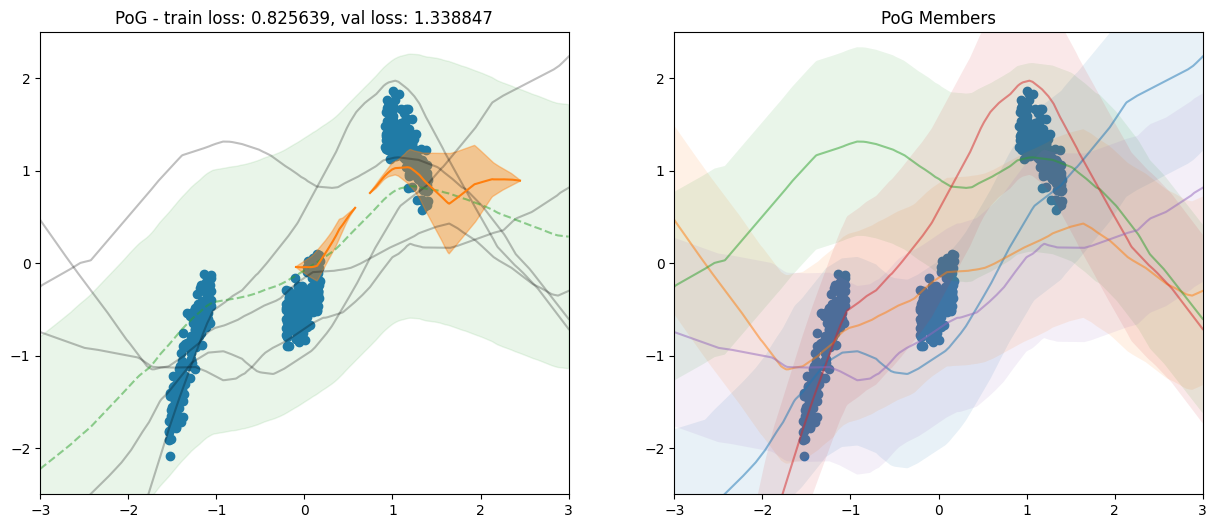

epoch:  41 - ('train loss: 0.81539, val loss: 1.32140, train err:    nan, val err:    nan, β: 2.6577, lr: 0.00010, prod_nll: 0.47826', ', members_nll: 1.15252')
epoch:  42 - ('train loss: 0.80515, val loss: 1.30516, train err:    nan, val err:    nan, β: 2.6896, lr: 0.00010, prod_nll: 0.46947', ', members_nll: 1.14083')
epoch:  43 - ('train loss: 0.79500, val loss: 1.29052, train err:    nan, val err:    nan, β: 2.7230, lr: 0.00010, prod_nll: 0.46058', ', members_nll: 1.12943')
epoch:  44 - ('train loss: 0.78519, val loss: 1.27711, train err:    nan, val err:    nan, β: 2.7578, lr: 0.00010, prod_nll: 0.45171', ', members_nll: 1.11868')
epoch:  45 - ('train loss: 0.77546, val loss: 1.26388, train err:    nan, val err:    nan, β: 2.7943, lr: 0.00010, prod_nll: 0.44264', ', members_nll: 1.10828')
epoch:  46 - ('train loss: 0.76570, val loss: 1.25144, train err:    nan, val err:    nan, β: 2.8324, lr: 0.00010, prod_nll: 0.43332', ', members_nll: 1.09808')
epoch:  47 - ('train loss: 0.75586

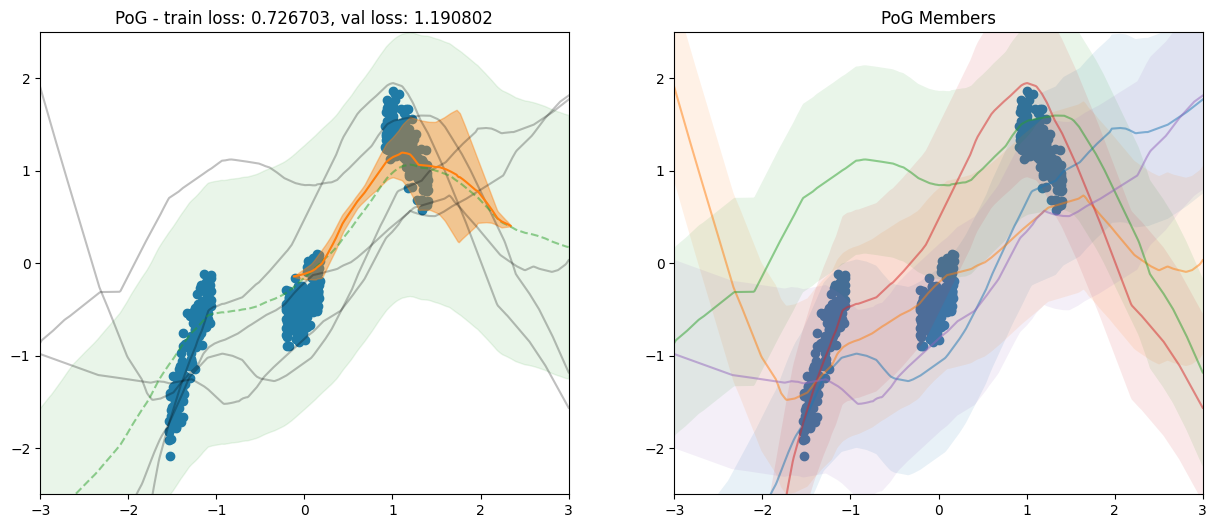

epoch:  51 - ('train loss: 0.71699, val loss: 1.17538, train err:    nan, val err:    nan, β: 3.0499, lr: 0.00010, prod_nll: 0.38386', ', members_nll: 1.05012')
epoch:  52 - ('train loss: 0.70735, val loss: 1.16070, train err:    nan, val err:    nan, β: 3.0992, lr: 0.00010, prod_nll: 0.37353', ', members_nll: 1.04117')
epoch:  53 - ('train loss: 0.69744, val loss: 1.14668, train err:    nan, val err:    nan, β: 3.1507, lr: 0.00010, prod_nll: 0.36271', ', members_nll: 1.03217')
epoch:  54 - ('train loss: 0.68772, val loss: 1.13327, train err:    nan, val err:    nan, β: 3.2043, lr: 0.00010, prod_nll: 0.35177', ', members_nll: 1.02367')
epoch:  55 - ('train loss: 0.67799, val loss: 1.12037, train err:    nan, val err:    nan, β: 3.2602, lr: 0.00010, prod_nll: 0.34075', ', members_nll: 1.01523')
epoch:  56 - ('train loss: 0.66803, val loss: 1.10799, train err:    nan, val err:    nan, β: 3.3185, lr: 0.00010, prod_nll: 0.32948', ', members_nll: 1.00658')
epoch:  57 - ('train loss: 0.65808

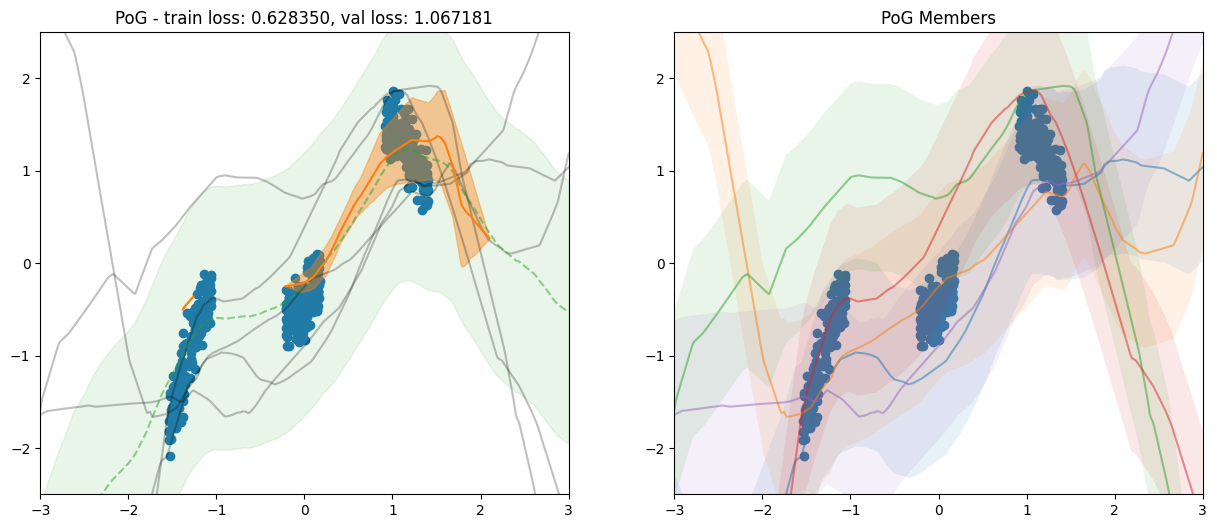

epoch:  61 - ('train loss: 0.61828, val loss: 1.05812, train err:    nan, val err:    nan, β: 3.6470, lr: 0.00010, prod_nll: 0.27037', ', members_nll: 0.96618')
epoch:  62 - ('train loss: 0.60819, val loss: 1.04996, train err:    nan, val err:    nan, β: 3.7207, lr: 0.00010, prod_nll: 0.25811', ', members_nll: 0.95827')
epoch:  63 - ('train loss: 0.59831, val loss: 1.04337, train err:    nan, val err:    nan, β: 3.7972, lr: 0.00010, prod_nll: 0.24577', ', members_nll: 0.95086')
epoch:  64 - ('train loss: 0.58833, val loss: 1.03663, train err:    nan, val err:    nan, β: 3.8766, lr: 0.00010, prod_nll: 0.23305', ', members_nll: 0.94361')
epoch:  65 - ('train loss: 0.57846, val loss: 1.02944, train err:    nan, val err:    nan, β: 3.9589, lr: 0.00010, prod_nll: 0.22041', ', members_nll: 0.93651')
epoch:  66 - ('train loss: 0.56813, val loss: 1.02291, train err:    nan, val err:    nan, β: 4.0443, lr: 0.00010, prod_nll: 0.20747', ', members_nll: 0.92879')
epoch:  67 - ('train loss: 0.55849

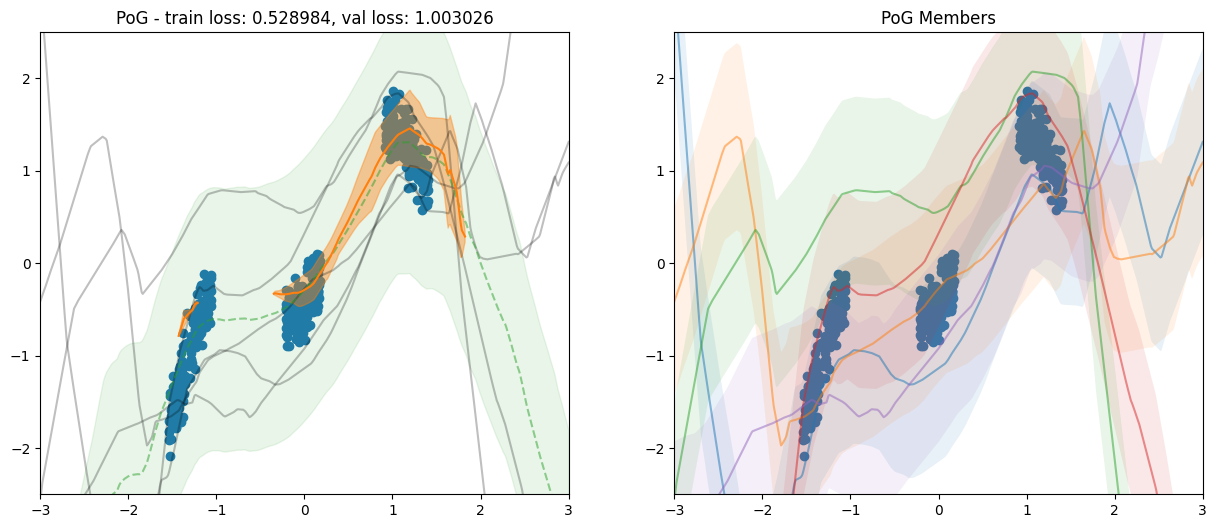

epoch:  71 - ('train loss: 0.51945, val loss: 0.99958, train err: 0.0523, val err:    nan, β: 4.5178, lr: 0.00010, prod_nll: 0.14328', ', members_nll: 0.89562')
epoch:  72 - ('train loss: 0.51023, val loss: 0.99226, train err: 0.0517, val err:    nan, β: 4.6222, lr: 0.00010, prod_nll: 0.13075', ', members_nll: 0.88972')
epoch:  73 - ('train loss: 0.50080, val loss: 0.98423, train err: 0.0509, val err:    nan, β: 4.7299, lr: 0.00010, prod_nll: 0.11815', ', members_nll: 0.88344')
epoch:  74 - ('train loss: 0.49200, val loss: 0.97890, train err: 0.0503, val err:    nan, β: 4.8408, lr: 0.00010, prod_nll: 0.10603', ', members_nll: 0.87796')
epoch:  75 - ('train loss: 0.48423, val loss: 0.96544, train err: 0.0502, val err:    nan, β: 4.9552, lr: 0.00010, prod_nll: 0.09442', ', members_nll: 0.87403')
epoch:  76 - ('train loss: 0.47563, val loss: 0.94173, train err: 0.0495, val err:    nan, β: 5.0728, lr: 0.00010, prod_nll: 0.08259', ', members_nll: 0.86868')
epoch:  77 - ('train loss: 0.46613

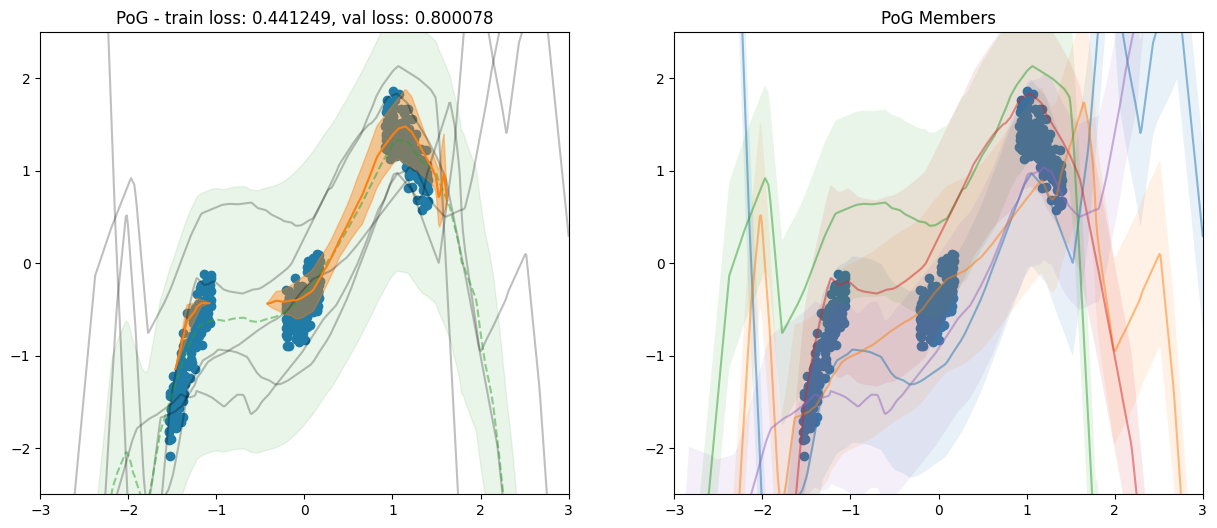

epoch:  81 - ('train loss: 0.43315, val loss: 0.75762, train err: 0.0446, val err:    nan, β: 5.7107, lr: 0.00010, prod_nll: 0.02536', ', members_nll: 0.84094')
epoch:  82 - ('train loss: 0.42513, val loss: 0.71566, train err: 0.0437, val err: 0.0945, β: 5.8479, lr: 0.00010, prod_nll: 0.01450', ', members_nll: 0.83575')
epoch:  83 - ('train loss: 0.41719, val loss: 0.67636, train err: 0.0428, val err: 0.0873, β: 5.9883, lr: 0.00010, prod_nll: 0.00376', ', members_nll: 0.83062')
epoch:  84 - ('train loss: 0.40941, val loss: 0.64100, train err: 0.0419, val err: 0.0809, β: 6.1317, lr: 0.00010, prod_nll: -0.00674', ', members_nll: 0.82557')
epoch:  85 - ('train loss: 0.40184, val loss: 0.61084, train err: 0.0412, val err: 0.0753, β: 6.2780, lr: 0.00010, prod_nll: -0.01698', ', members_nll: 0.82066')
epoch:  86 - ('train loss: 0.39445, val loss: 0.58476, train err: 0.0404, val err: 0.0704, β: 6.4272, lr: 0.00010, prod_nll: -0.02699', ', members_nll: 0.81590')
epoch:  87 - ('train loss: 0.38

In [ ]:
best_pog_states = []
for i in range(1):
    for beta in BETA_END:
        for alpha in ALPHAS:
            rng = random.PRNGKey(i)
            setup_rng, rng = random.split(rng)
            
            config.model.members_ll_type = MEMBERS_LL.value
            config.β_schedule.end = beta
            config.alpha = alpha
            # config.epochs = 1001
            
            pog_model, state = setup_training(config, setup_rng, init_x, init_y)

            if POG_RETRAIN:  # RETRAIN
                state, best_state = train_loop(
                    pog_model, state, config, rng, 
                    partial(make_PoG_Ens_loss, per_member_loss=alpha), 
                    partial(make_PoG_Ens_loss, per_member_loss=alpha), 
                    train_loader, val_loader,
                    # test_loader,
                    wandb_kwargs={
                        'mode': 'online',
                        # 'notes': '',
                    },
                    plot_fn=make_PoG_Ens_plots,
                )

                best_pog_states.append(best_state)

                save_checkpoint(f'dynNN_results/pog_model_{i}_{MEMBERS_LL.value}_{alpha}_{beta}', 
                                best_state, 1, overwrite=True)

## 2. DE training

+---------------------------------------------+----------+-------+-----------+--------+
| Name                                        | Shape    | Size  | Mean      | Std    |
+---------------------------------------------+----------+-------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_0/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/mean | (50,)    | 50    | 0.0       | 0.0    |
| batch_stats/nets_1/layer_1/BatchNorm_0/var  | (50,)    | 50    | 1.0       | 0.0    |
| batch_stats/nets_2/layer_0/Bat

2022-10-20 16:41:40.164115: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-20 16:41:40.683104: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-20 16:41:40.683169: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-20 16:41:40.683176: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


  0%|          | 0/401 [00:00<?, ?it/s]

epoch:   1 - ('train loss: 9.37605, val loss: 8.40488, train err: 0.6576, val err: 1.1158, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 9.37605')
Best val_err
epoch:   2 - ('train loss: 9.07562, val loss: 8.41479, train err: 0.5667, val err: 1.1073, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 9.07562')
Best val_err
epoch:   3 - ('train loss: 8.79693, val loss: 8.40273, train err: 0.5247, val err: 1.0937, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 8.79693')
Best val_err
epoch:   4 - ('train loss: 8.54458, val loss: 8.37113, train err: 0.4857, val err: 1.0759, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 8.54458')
Best val_err
epoch:   5 - ('train loss: 8.26922, val loss: 8.32121, train err: 0.4435, val err: 1.0540, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 8.26922')
Best val_err
epoch:   6 - ('train loss: 7.97910, val loss: 8.25471, train err: 0.3998, val err: 1.0282, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 7.97910')
Best val_err
epoch:   7 - ('train l

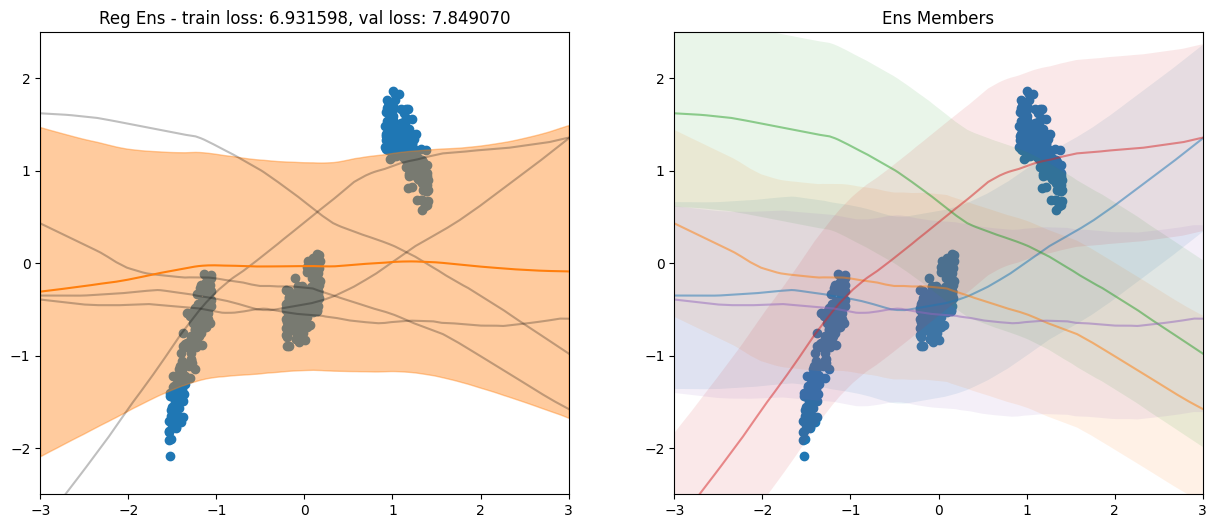

Best val_err
epoch:  11 - ('train loss: 6.72822, val loss: 7.73086, train err: 0.2075, val err: 0.8560, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 6.72822')
Best val_err
epoch:  12 - ('train loss: 6.55196, val loss: 7.61018, train err: 0.1815, val err: 0.8178, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 6.55196')
Best val_err
epoch:  13 - ('train loss: 6.39606, val loss: 7.48863, train err: 0.1583, val err: 0.7793, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 6.39606')
Best val_err
epoch:  14 - ('train loss: 6.26974, val loss: 7.36732, train err: 0.1443, val err: 0.7406, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 6.26974')
Best val_err
epoch:  15 - ('train loss: 6.15757, val loss: 7.24767, train err: 0.1288, val err: 0.7027, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 6.15757')
Best val_err
epoch:  16 - ('train loss: 6.06181, val loss: 7.13082, train err: 0.1163, val err: 0.6658, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 6.06181')
Best val_err
epoch:  1

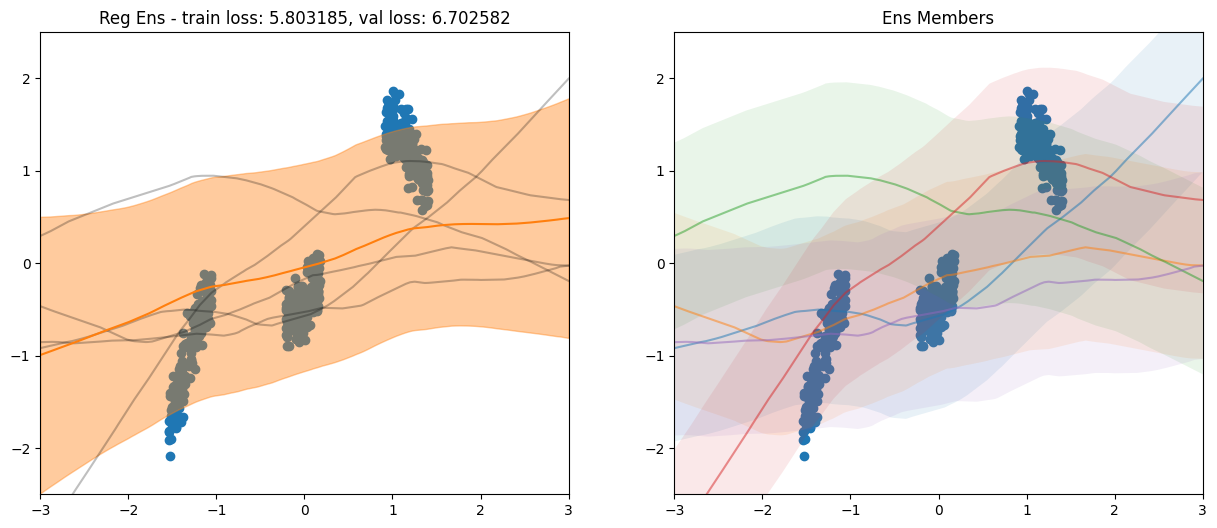

Best val_err
epoch:  21 - ('train loss: 5.75738, val loss: 6.60674, train err: 0.0868, val err: 0.5022, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.75738')
Best val_err
epoch:  22 - ('train loss: 5.71530, val loss: 6.51677, train err: 0.0844, val err: 0.4747, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.71530')
Best val_err
epoch:  23 - ('train loss: 5.67594, val loss: 6.43222, train err: 0.0822, val err: 0.4492, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.67594')
Best val_err
epoch:  24 - ('train loss: 5.63864, val loss: 6.35240, train err: 0.0804, val err: 0.4253, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.63864')
Best val_err
epoch:  25 - ('train loss: 5.60188, val loss: 6.27703, train err: 0.0789, val err: 0.4032, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.60188')
Best val_err
epoch:  26 - ('train loss: 5.56558, val loss: 6.20527, train err: 0.0775, val err: 0.3824, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.56558')
Best val_err
epoch:  2

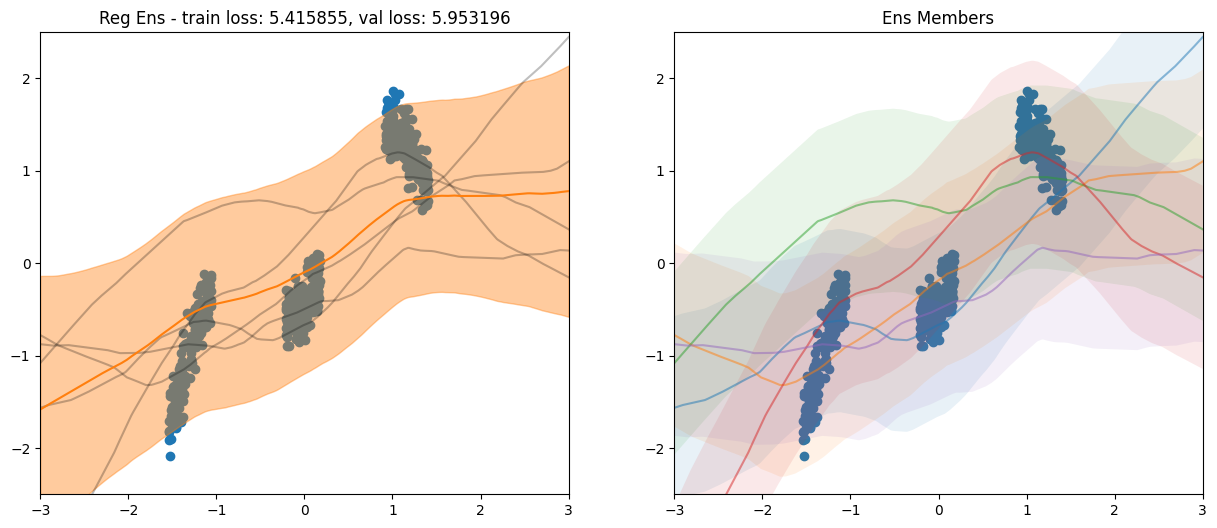

Best val_err
epoch:  31 - ('train loss: 5.37659, val loss: 5.89829, train err: 0.0703, val err: 0.2998, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.37659')
Best val_err
epoch:  32 - ('train loss: 5.33720, val loss: 5.84588, train err: 0.0686, val err: 0.2871, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.33720')
Best val_err
epoch:  33 - ('train loss: 5.29763, val loss: 5.79600, train err: 0.0670, val err: 0.2755, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.29763')
Best val_err
epoch:  34 - ('train loss: 5.25795, val loss: 5.74831, train err: 0.0654, val err: 0.2647, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.25795')
Best val_err
epoch:  35 - ('train loss: 5.21831, val loss: 5.70236, train err: 0.0639, val err: 0.2545, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.21831')
Best val_err
epoch:  36 - ('train loss: 5.17879, val loss: 5.65837, train err: 0.0624, val err: 0.2453, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 5.17879')
Best val_err
epoch:  3

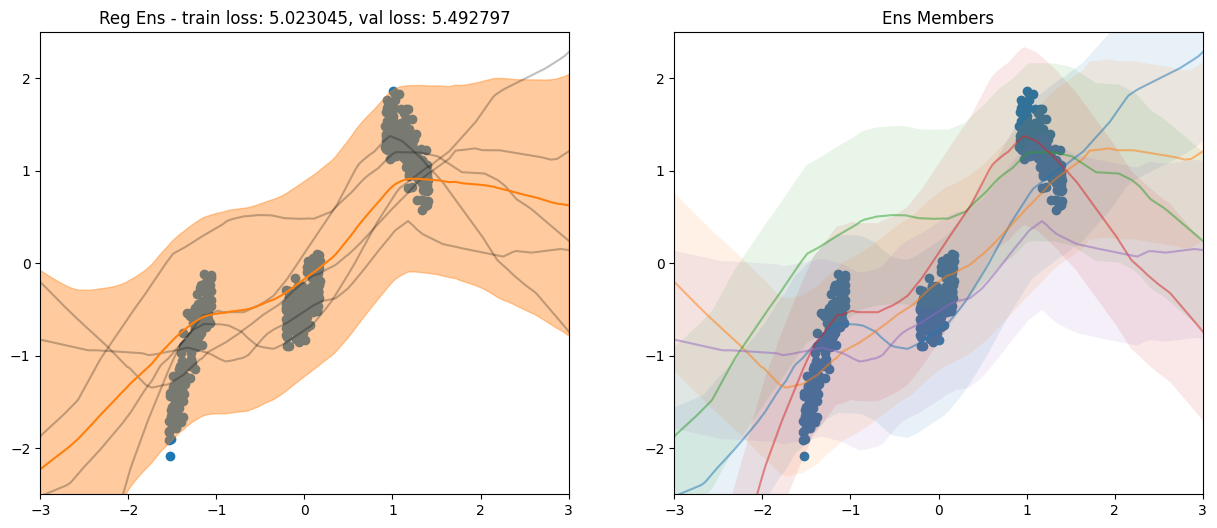

Best val_err
epoch:  41 - ('train loss: 4.98515, val loss: 5.45320, train err: 0.0556, val err: 0.2058, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.98515')
Best val_err
epoch:  42 - ('train loss: 4.94795, val loss: 5.41384, train err: 0.0545, val err: 0.1986, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.94795')
Best val_err
epoch:  43 - ('train loss: 4.91160, val loss: 5.37442, train err: 0.0534, val err: 0.1915, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.91160')
Best val_err
epoch:  44 - ('train loss: 4.87616, val loss: 5.33482, train err: 0.0525, val err: 0.1844, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.87616')
Best val_err
epoch:  45 - ('train loss: 4.84141, val loss: 5.29473, train err: 0.0516, val err: 0.1773, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.84141')
Best val_err
epoch:  46 - ('train loss: 4.80733, val loss: 5.25471, train err: 0.0507, val err: 0.1704, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.80733')
Best val_err
epoch:  4

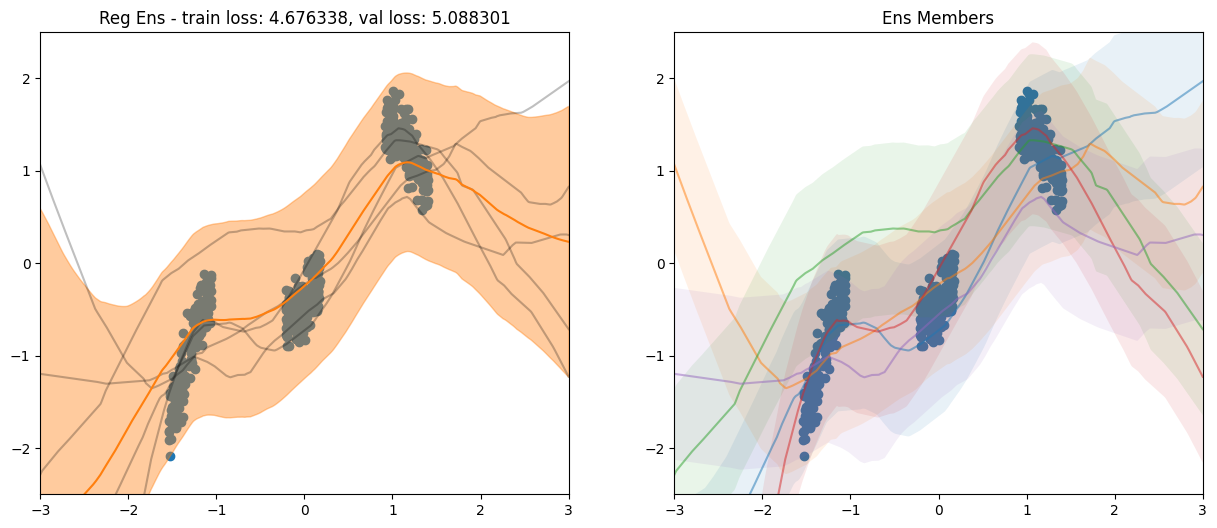

Best val_err
epoch:  51 - ('train loss: 4.64515, val loss: 5.04574, train err: 0.0473, val err: 0.1367, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.64515')
Best val_err
epoch:  52 - ('train loss: 4.61440, val loss: 5.00380, train err: 0.0468, val err: 0.1309, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.61440')
Best val_err
epoch:  53 - ('train loss: 4.58407, val loss: 4.96241, train err: 0.0463, val err: 0.1256, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.58407')
Best val_err
epoch:  54 - ('train loss: 4.55397, val loss: 4.92160, train err: 0.0459, val err: 0.1206, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.55397')
Best val_err
epoch:  55 - ('train loss: 4.52408, val loss: 4.88144, train err: 0.0454, val err: 0.1160, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.52408')
Best val_err
epoch:  56 - ('train loss: 4.49448, val loss: 4.84174, train err: 0.0450, val err: 0.1118, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.49448')
Best val_err
epoch:  5

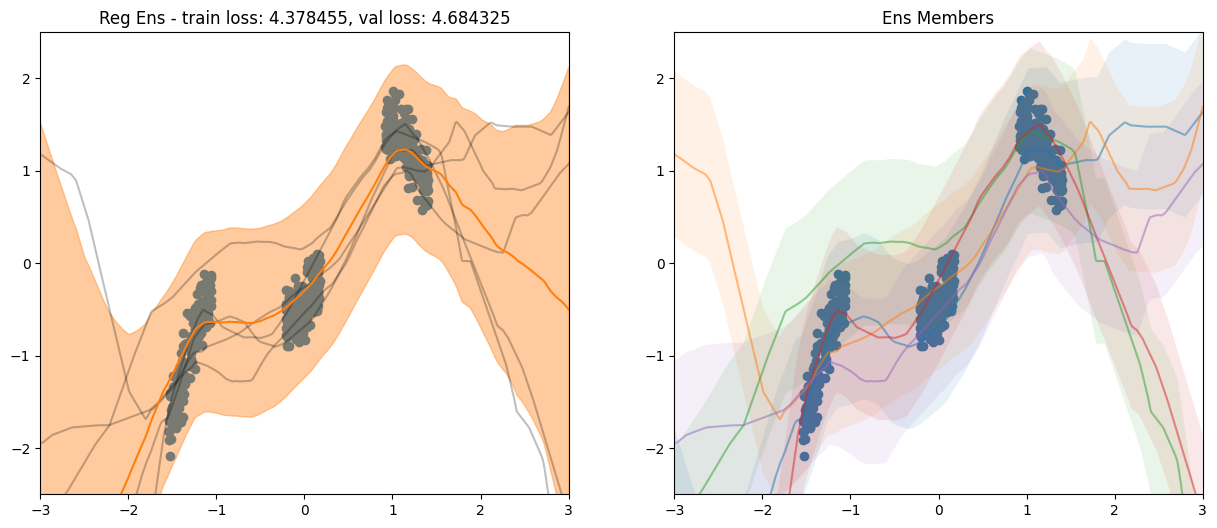

Best val_err
epoch:  61 - ('train loss: 4.35006, val loss: 4.64538, train err: 0.0431, val err: 0.0942, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.35006')
Best val_err
epoch:  62 - ('train loss: 4.32186, val loss: 4.60680, train err: 0.0428, val err: 0.0913, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.32186')
Best val_err
epoch:  63 - ('train loss: 4.29388, val loss: 4.56853, train err: 0.0425, val err: 0.0885, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.29388')
Best val_err
epoch:  64 - ('train loss: 4.26611, val loss: 4.53070, train err: 0.0421, val err: 0.0860, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.26611')
Best val_err
epoch:  65 - ('train loss: 4.23856, val loss: 4.49316, train err: 0.0418, val err: 0.0837, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.23856')
Best val_err
epoch:  66 - ('train loss: 4.21119, val loss: 4.45597, train err: 0.0415, val err: 0.0815, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.21119')
Best val_err
epoch:  6

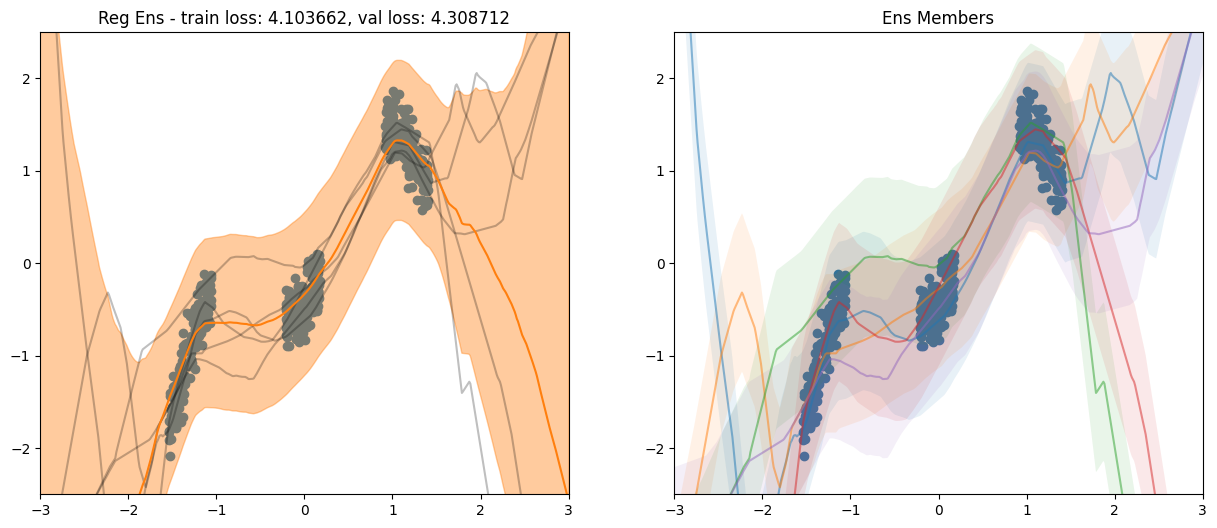

Best val_err
epoch:  71 - ('train loss: 4.07714, val loss: 4.27325, train err: 0.0402, val err: 0.0726, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.07714')
Best val_err
epoch:  72 - ('train loss: 4.05076, val loss: 4.23800, train err: 0.0399, val err: 0.0712, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.05076')
Best val_err
epoch:  73 - ('train loss: 4.02452, val loss: 4.20298, train err: 0.0397, val err: 0.0699, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 4.02452')
Best val_err
epoch:  74 - ('train loss: 3.99850, val loss: 4.16766, train err: 0.0395, val err: 0.0686, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.99850')
Best val_err
epoch:  75 - ('train loss: 3.97261, val loss: 4.13260, train err: 0.0392, val err: 0.0672, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.97261')
Best val_err
epoch:  76 - ('train loss: 3.94684, val loss: 4.09745, train err: 0.0390, val err: 0.0658, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.94684')
Best val_err
epoch:  7

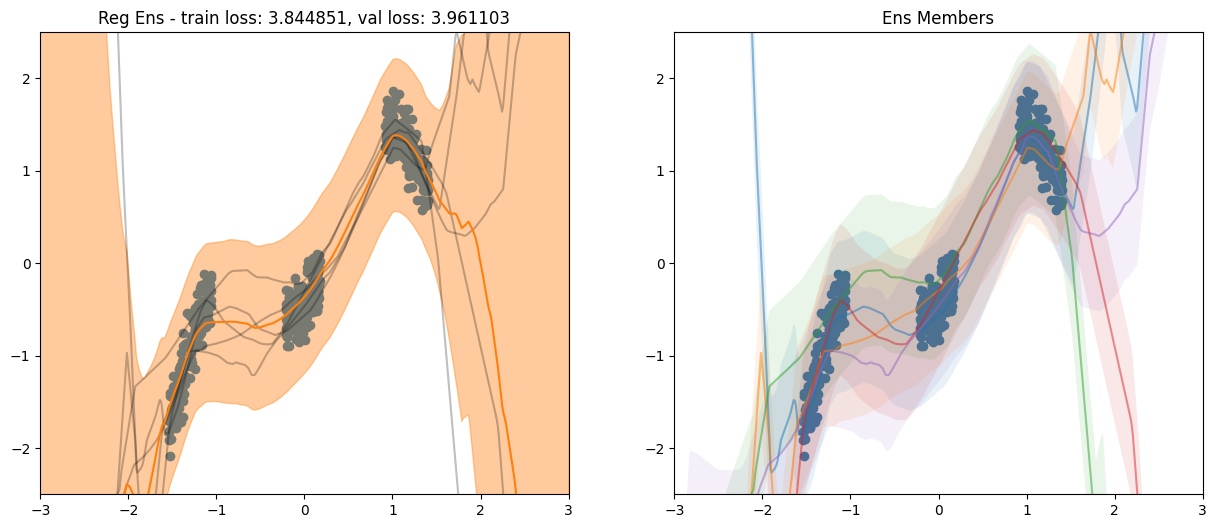

Best val_err
epoch:  81 - ('train loss: 3.81957, val loss: 3.92866, train err: 0.0380, val err: 0.0597, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.81957')
Best val_err
epoch:  82 - ('train loss: 3.79434, val loss: 3.89703, train err: 0.0378, val err: 0.0587, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.79434')
Best val_err
epoch:  83 - ('train loss: 3.76916, val loss: 3.86619, train err: 0.0376, val err: 0.0578, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.76916')
Best val_err
epoch:  84 - ('train loss: 3.74407, val loss: 3.83623, train err: 0.0374, val err: 0.0569, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.74407')
Best val_err
epoch:  85 - ('train loss: 3.71898, val loss: 3.80710, train err: 0.0372, val err: 0.0560, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.71898')
Best val_err
epoch:  86 - ('train loss: 3.69384, val loss: 3.77875, train err: 0.0370, val err: 0.0552, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.69384')
Best val_err
epoch:  8

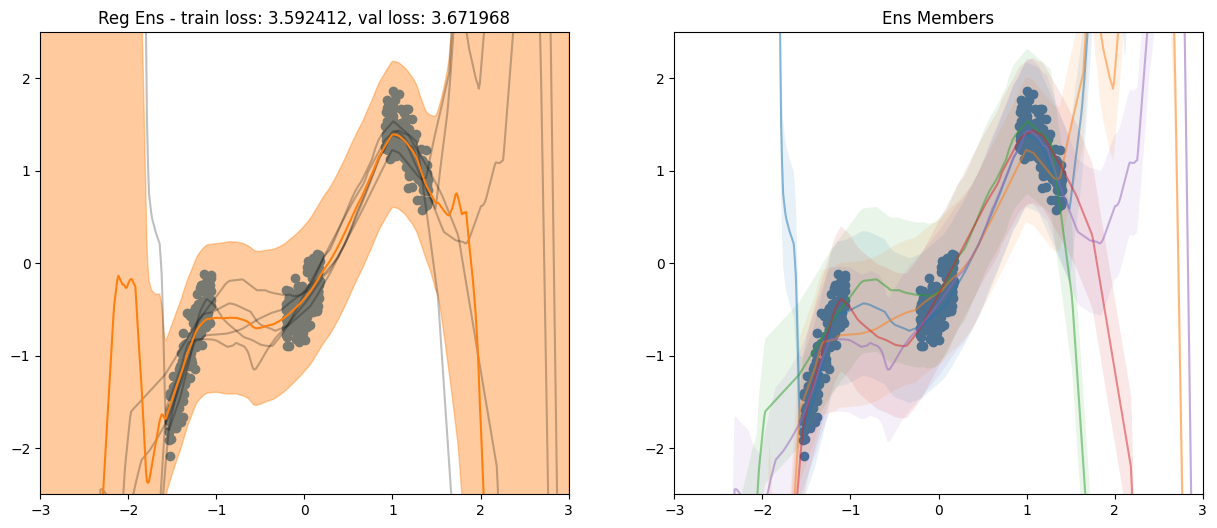

Best val_err
epoch:  91 - ('train loss: 3.56668, val loss: 3.64705, train err: 0.0357, val err: 0.0521, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.56668')
Best val_err
epoch:  92 - ('train loss: 3.54101, val loss: 3.62284, train err: 0.0354, val err: 0.0517, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.54101')
Best val_err
epoch:  93 - ('train loss: 3.51604, val loss: 3.59898, train err: 0.0351, val err: 0.0513, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.51604')
Best val_err
epoch:  94 - ('train loss: 3.49283, val loss: 3.57490, train err: 0.0349, val err: 0.0510, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.49283')
Best val_err
epoch:  95 - ('train loss: 3.47076, val loss: 3.54998, train err: 0.0348, val err: 0.0506, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.47076')
Best val_err
epoch:  96 - ('train loss: 3.44785, val loss: 3.52396, train err: 0.0347, val err: 0.0501, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.44785')
Best val_err
epoch:  9

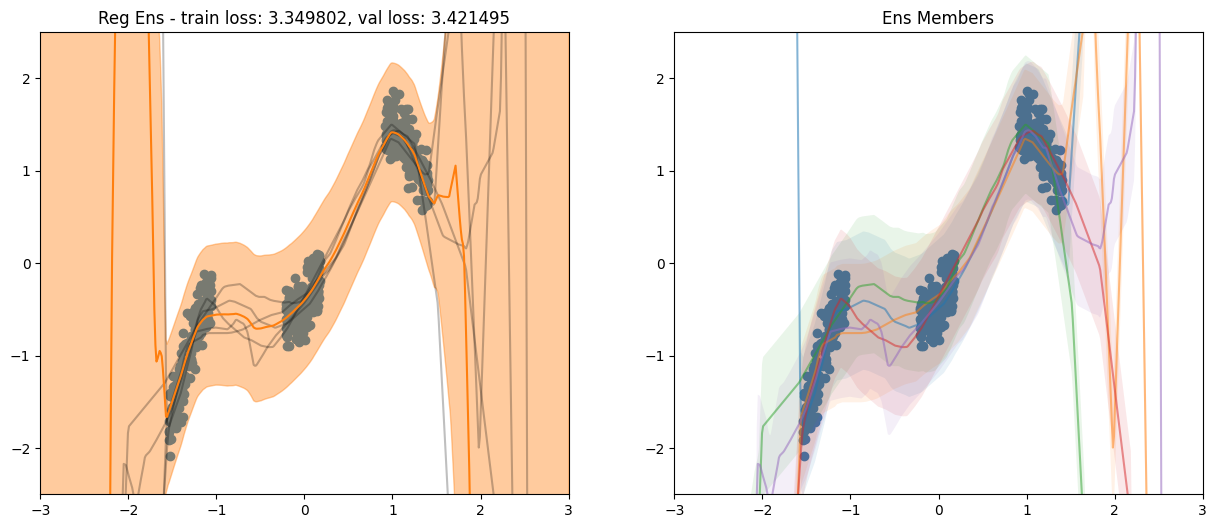

Best val_err
epoch: 101 - ('train loss: 3.32722, val loss: 3.39771, train err: 0.0341, val err: 0.0476, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.32722')
Best val_err
epoch: 102 - ('train loss: 3.30459, val loss: 3.37424, train err: 0.0340, val err: 0.0473, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.30459')
Best val_err
epoch: 103 - ('train loss: 3.28152, val loss: 3.35088, train err: 0.0339, val err: 0.0471, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.28152')
Best val_err
epoch: 104 - ('train loss: 3.25786, val loss: 3.32760, train err: 0.0337, val err: 0.0468, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.25786')
Best val_err
epoch: 105 - ('train loss: 3.23384, val loss: 3.30440, train err: 0.0335, val err: 0.0466, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.23384')
Best val_err
epoch: 106 - ('train loss: 3.21007, val loss: 3.28138, train err: 0.0333, val err: 0.0464, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.21007')
Best val_err
epoch: 10

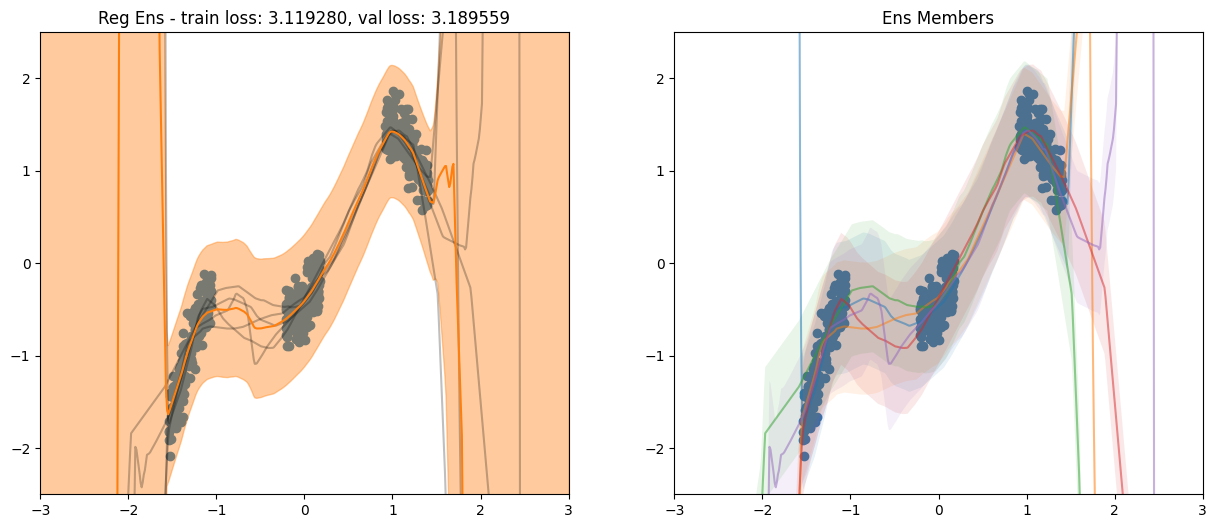

Best val_err
epoch: 111 - ('train loss: 3.09584, val loss: 3.16704, train err: 0.0329, val err: 0.0451, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.09584')
Best val_err
epoch: 112 - ('train loss: 3.07280, val loss: 3.14471, train err: 0.0327, val err: 0.0448, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.07280')
Best val_err
epoch: 113 - ('train loss: 3.05035, val loss: 3.12229, train err: 0.0326, val err: 0.0445, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.05035')
Best val_err
epoch: 114 - ('train loss: 3.02805, val loss: 3.09953, train err: 0.0326, val err: 0.0442, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.02805')
Best val_err
epoch: 115 - ('train loss: 3.00545, val loss: 3.07662, train err: 0.0325, val err: 0.0440, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 3.00545')
Best val_err
epoch: 116 - ('train loss: 2.98252, val loss: 3.05361, train err: 0.0324, val err: 0.0438, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.98252')
Best val_err
epoch: 11

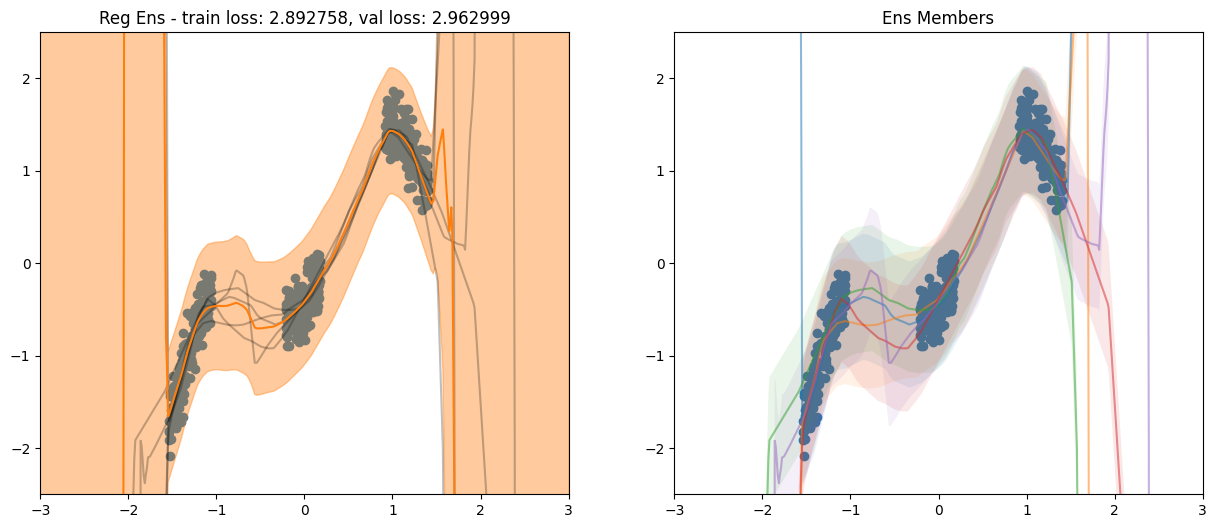

Best val_err
epoch: 121 - ('train loss: 2.87032, val loss: 2.94030, train err: 0.0320, val err: 0.0427, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.87032')
Best val_err
epoch: 122 - ('train loss: 2.84785, val loss: 2.91774, train err: 0.0319, val err: 0.0424, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.84785')
Best val_err
epoch: 123 - ('train loss: 2.82560, val loss: 2.89540, train err: 0.0319, val err: 0.0422, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.82560')
Best val_err
epoch: 124 - ('train loss: 2.80358, val loss: 2.87293, train err: 0.0318, val err: 0.0421, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.80358')
Best val_err
epoch: 125 - ('train loss: 2.78159, val loss: 2.85004, train err: 0.0318, val err: 0.0420, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.78159')
Best val_err
epoch: 126 - ('train loss: 2.75952, val loss: 2.82655, train err: 0.0317, val err: 0.0419, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.75952')
Best val_err
epoch: 12

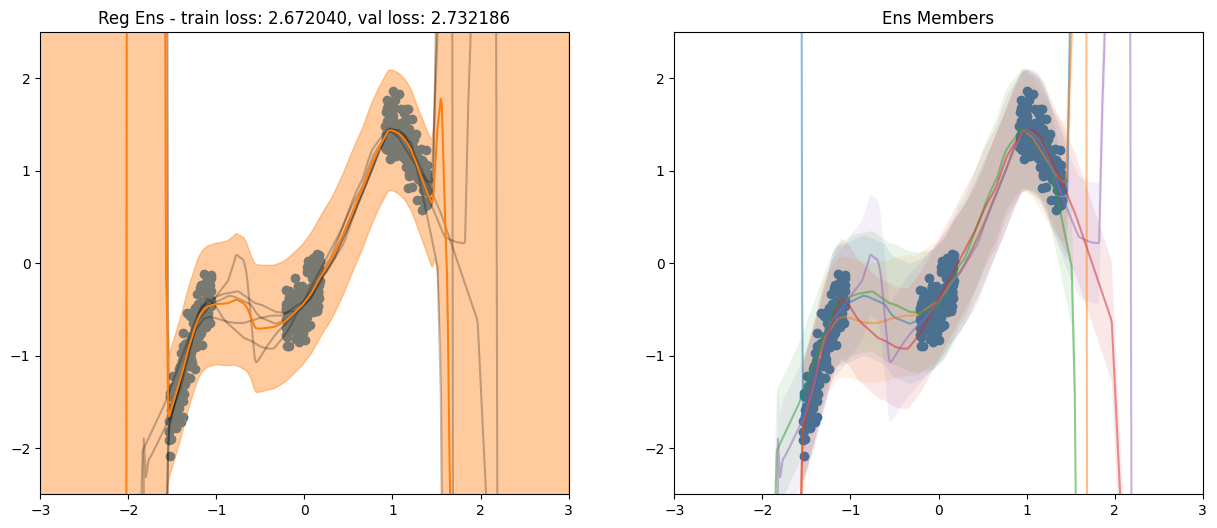

Best val_err
epoch: 131 - ('train loss: 2.65029, val loss: 2.70897, train err: 0.0316, val err: 0.0412, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.65029')
Best val_err
epoch: 132 - ('train loss: 2.62855, val loss: 2.68582, train err: 0.0316, val err: 0.0411, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.62855')
Best val_err
epoch: 133 - ('train loss: 2.60691, val loss: 2.66289, train err: 0.0316, val err: 0.0410, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.60691')
Best val_err
epoch: 134 - ('train loss: 2.58540, val loss: 2.63983, train err: 0.0316, val err: 0.0408, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.58540')
Best val_err
epoch: 135 - ('train loss: 2.56395, val loss: 2.61666, train err: 0.0316, val err: 0.0407, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.56395')
Best val_err
epoch: 136 - ('train loss: 2.54248, val loss: 2.59335, train err: 0.0315, val err: 0.0406, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.54248')
Best val_err
epoch: 13

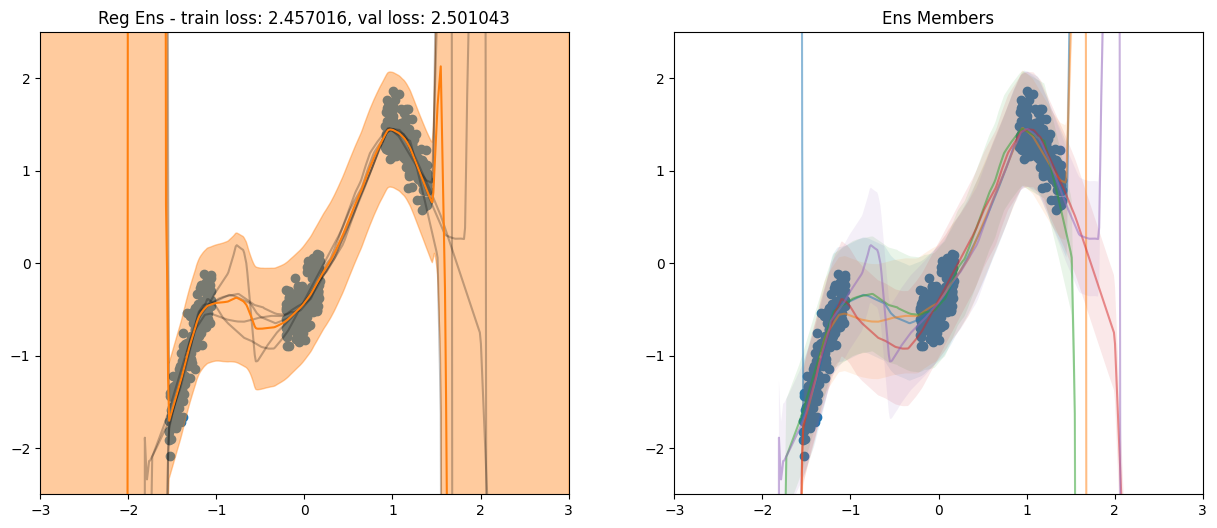

Best val_err
epoch: 141 - ('train loss: 2.43572, val loss: 2.47925, train err: 0.0315, val err: 0.0401, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.43572')
Best val_err
epoch: 142 - ('train loss: 2.41443, val loss: 2.45773, train err: 0.0315, val err: 0.0401, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.41443')
Best val_err
epoch: 143 - ('train loss: 2.39320, val loss: 2.43617, train err: 0.0315, val err: 0.0400, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.39320')
Best val_err
epoch: 144 - ('train loss: 2.37201, val loss: 2.41465, train err: 0.0314, val err: 0.0400, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.37201')
Best val_err
epoch: 145 - ('train loss: 2.35084, val loss: 2.39314, train err: 0.0314, val err: 0.0399, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.35084')
Best val_err
epoch: 146 - ('train loss: 2.32968, val loss: 2.37183, train err: 0.0314, val err: 0.0399, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.32968')
Best val_err
epoch: 14

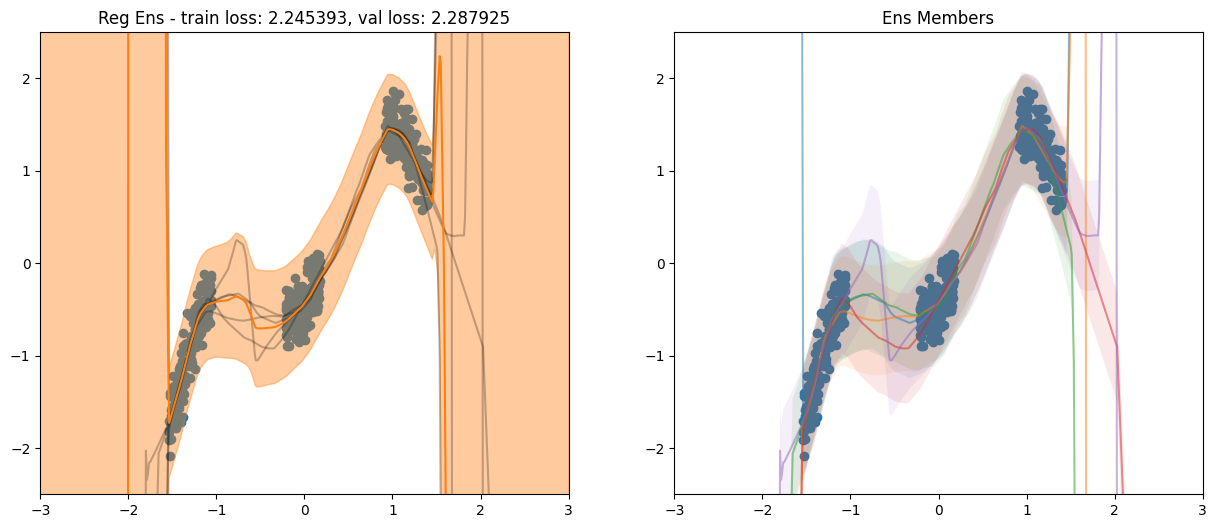

Best val_err
epoch: 151 - ('train loss: 2.22440, val loss: 2.26737, train err: 0.0314, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.22440')
Best val_err
epoch: 152 - ('train loss: 2.20346, val loss: 2.24709, train err: 0.0313, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.20346')
Best val_err
epoch: 153 - ('train loss: 2.18257, val loss: 2.22674, train err: 0.0313, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.18257')
Best val_err
epoch: 154 - ('train loss: 2.16172, val loss: 2.20606, train err: 0.0313, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.16172')
Best val_err
epoch: 155 - ('train loss: 2.14090, val loss: 2.18525, train err: 0.0313, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.14090')
Best val_err
epoch: 156 - ('train loss: 2.12011, val loss: 2.16466, train err: 0.0313, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.12011')
Best val_err
epoch: 15

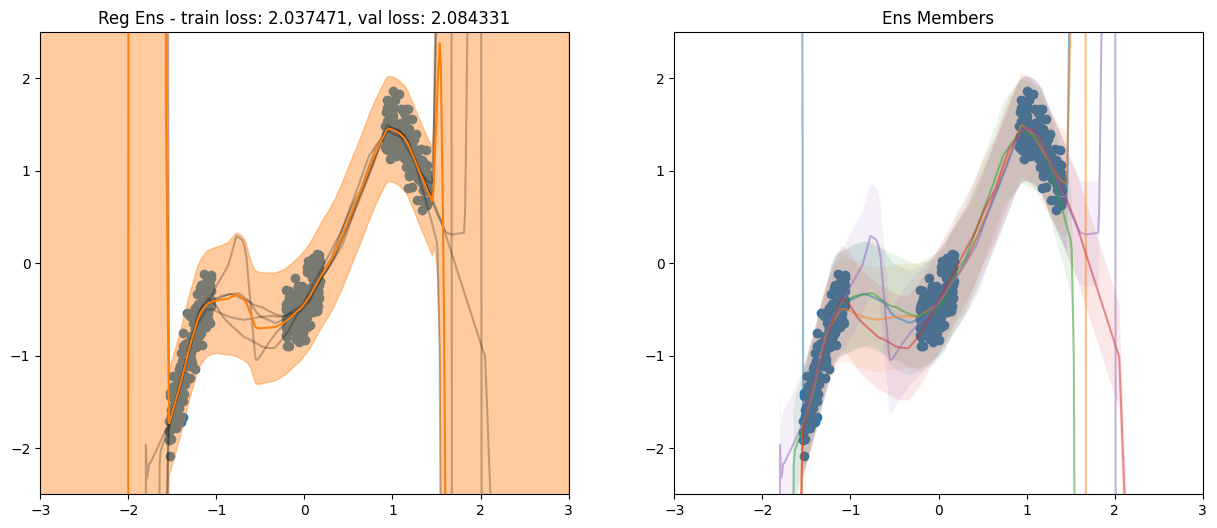

epoch: 161 - ('train loss: 2.01689, val loss: 2.06437, train err: 0.0313, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 2.01689')
epoch: 162 - ('train loss: 1.99635, val loss: 2.04463, train err: 0.0313, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.99635')
epoch: 163 - ('train loss: 1.97584, val loss: 2.02488, train err: 0.0313, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.97584')
epoch: 164 - ('train loss: 1.95538, val loss: 2.00487, train err: 0.0313, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.95538')
epoch: 165 - ('train loss: 1.93498, val loss: 1.98456, train err: 0.0313, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.93498')
epoch: 166 - ('train loss: 1.91461, val loss: 1.96473, train err: 0.0313, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.91461')
epoch: 167 - ('train loss: 1.89428, val loss: 1.94546, train err: 0.0312, val err: 0.0395, lr: 0.000

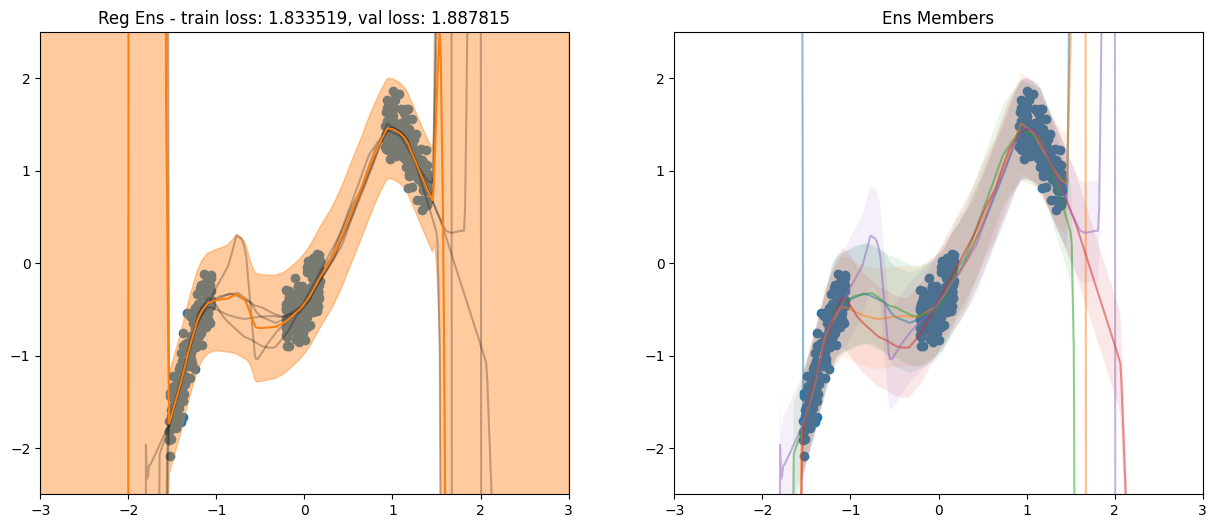

epoch: 171 - ('train loss: 1.81333, val loss: 1.86819, train err: 0.0312, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.81333')
epoch: 172 - ('train loss: 1.79320, val loss: 1.84878, train err: 0.0312, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.79320')
epoch: 173 - ('train loss: 1.77311, val loss: 1.82960, train err: 0.0312, val err: 0.0397, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.77311')
epoch: 174 - ('train loss: 1.75305, val loss: 1.81031, train err: 0.0312, val err: 0.0397, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.75305')
epoch: 175 - ('train loss: 1.73304, val loss: 1.79069, train err: 0.0312, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.73304')
epoch: 176 - ('train loss: 1.71306, val loss: 1.77118, train err: 0.0312, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.71306')
epoch: 177 - ('train loss: 1.69316, val loss: 1.75182, train err: 0.0312, val err: 0.0396, lr: 0.000

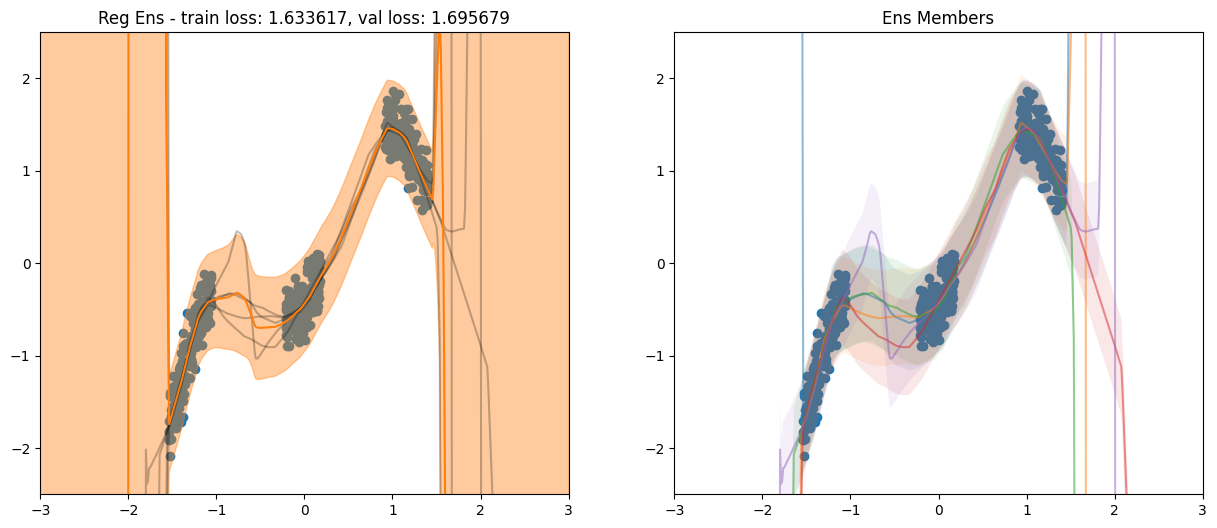

epoch: 181 - ('train loss: 1.61391, val loss: 1.67625, train err: 0.0312, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.61391')
epoch: 182 - ('train loss: 1.59413, val loss: 1.65647, train err: 0.0312, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.59413')
epoch: 183 - ('train loss: 1.57448, val loss: 1.63678, train err: 0.0312, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.57448')
epoch: 184 - ('train loss: 1.55489, val loss: 1.61789, train err: 0.0312, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.55489')
epoch: 185 - ('train loss: 1.53540, val loss: 1.59994, train err: 0.0312, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.53540')
epoch: 186 - ('train loss: 1.51588, val loss: 1.58128, train err: 0.0312, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.51588')
epoch: 187 - ('train loss: 1.49643, val loss: 1.56185, train err: 0.0312, val err: 0.0394, lr: 0.000

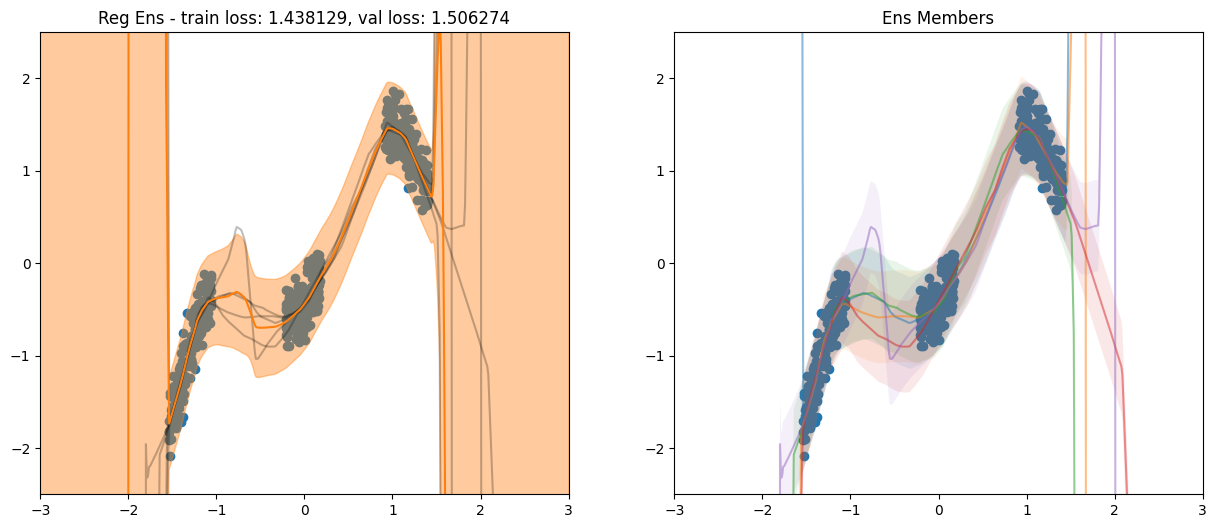

epoch: 191 - ('train loss: 1.41880, val loss: 1.48721, train err: 0.0311, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.41880')
epoch: 192 - ('train loss: 1.39947, val loss: 1.46896, train err: 0.0311, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.39947')
Best val_err
epoch: 193 - ('train loss: 1.38043, val loss: 1.45108, train err: 0.0311, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.38043')
epoch: 194 - ('train loss: 1.36130, val loss: 1.43369, train err: 0.0311, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.36130')
epoch: 195 - ('train loss: 1.34218, val loss: 1.41634, train err: 0.0311, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.34218')
epoch: 196 - ('train loss: 1.32316, val loss: 1.39724, train err: 0.0311, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.32316')
epoch: 197 - ('train loss: 1.30411, val loss: 1.37781, train err: 0.0311, val err: 0.03

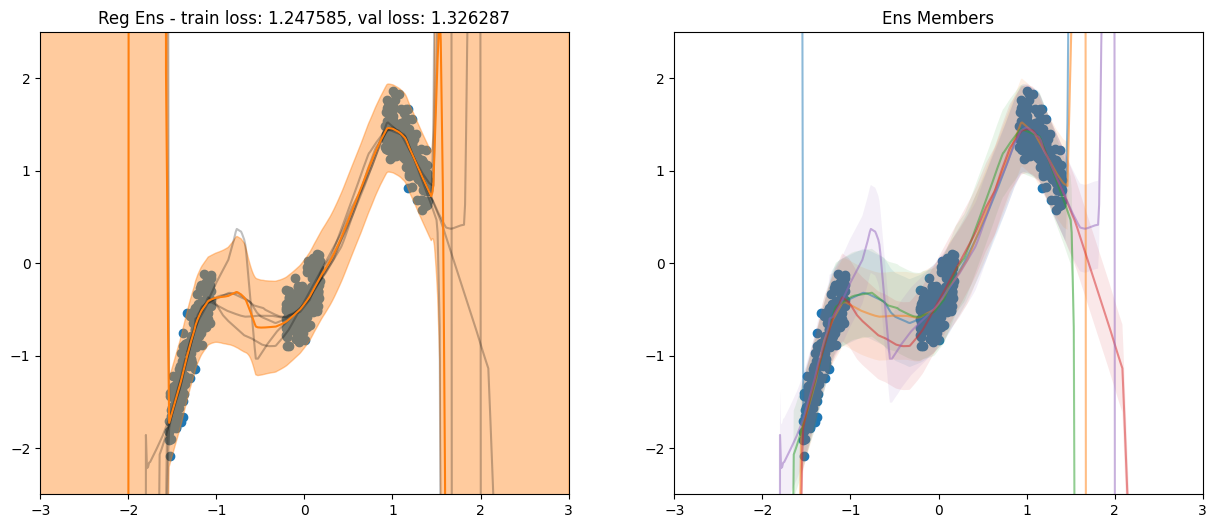

epoch: 201 - ('train loss: 1.22898, val loss: 1.30696, train err: 0.0311, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.22898')
epoch: 202 - ('train loss: 1.21010, val loss: 1.28811, train err: 0.0311, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.21010')
epoch: 203 - ('train loss: 1.19134, val loss: 1.27009, train err: 0.0311, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.19134')
epoch: 204 - ('train loss: 1.17250, val loss: 1.25339, train err: 0.0311, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.17250')
epoch: 205 - ('train loss: 1.15394, val loss: 1.23518, train err: 0.0311, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.15394')
epoch: 206 - ('train loss: 1.13535, val loss: 1.21748, train err: 0.0311, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.13535')
epoch: 207 - ('train loss: 1.11695, val loss: 1.19986, train err: 0.0311, val err: 0.0394, lr: 0.000

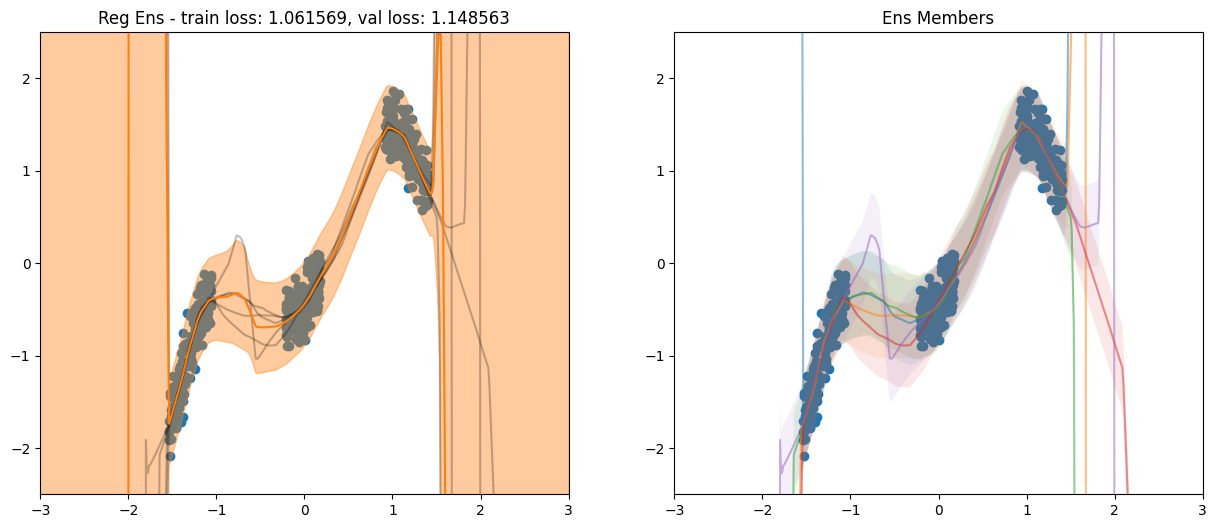

epoch: 211 - ('train loss: 1.04347, val loss: 1.13095, train err: 0.0311, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.04347')
epoch: 212 - ('train loss: 1.02527, val loss: 1.11396, train err: 0.0311, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.02527')
epoch: 213 - ('train loss: 1.00738, val loss: 1.09597, train err: 0.0311, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 1.00738')
epoch: 214 - ('train loss: 0.98891, val loss: 1.07924, train err: 0.0311, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.98891')
epoch: 215 - ('train loss: 0.97079, val loss: 1.06168, train err: 0.0311, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.97079')
epoch: 216 - ('train loss: 0.95278, val loss: 1.04598, train err: 0.0311, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.95278')
epoch: 217 - ('train loss: 0.93509, val loss: 1.03014, train err: 0.0311, val err: 0.0395, lr: 0.000

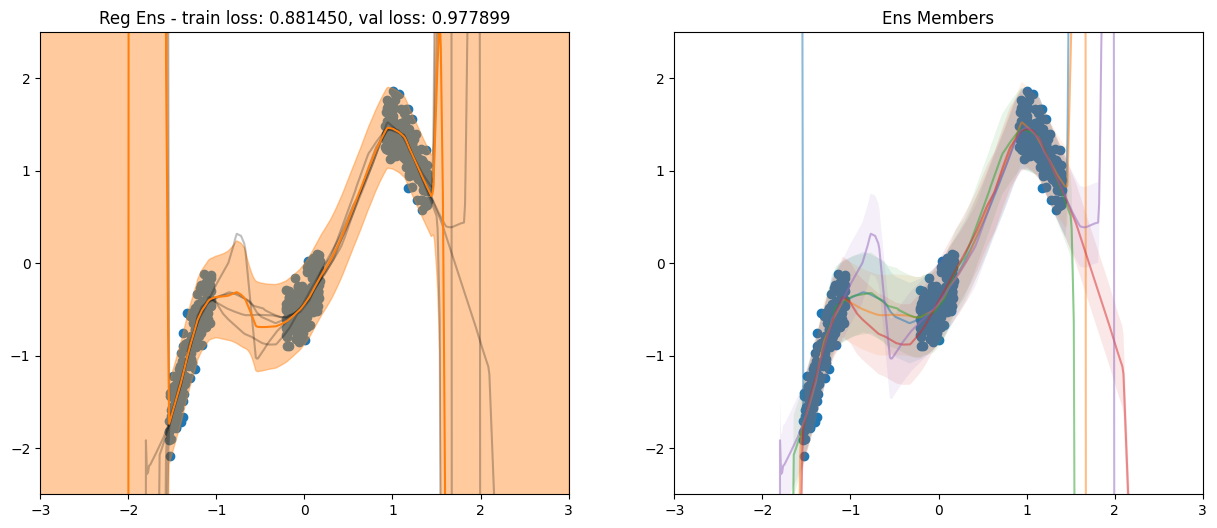

epoch: 221 - ('train loss: 0.86359, val loss: 0.95989, train err: 0.0311, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.86359')
epoch: 222 - ('train loss: 0.84591, val loss: 0.94459, train err: 0.0311, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.84591')
epoch: 223 - ('train loss: 0.82861, val loss: 0.92779, train err: 0.0311, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.82861')
epoch: 224 - ('train loss: 0.81089, val loss: 0.91127, train err: 0.0311, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.81089')
epoch: 225 - ('train loss: 0.79322, val loss: 0.89401, train err: 0.0311, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.79322')
epoch: 226 - ('train loss: 0.77568, val loss: 0.87768, train err: 0.0311, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.77568')
epoch: 227 - ('train loss: 0.75838, val loss: 0.86125, train err: 0.0311, val err: 0.0395, lr: 0.000

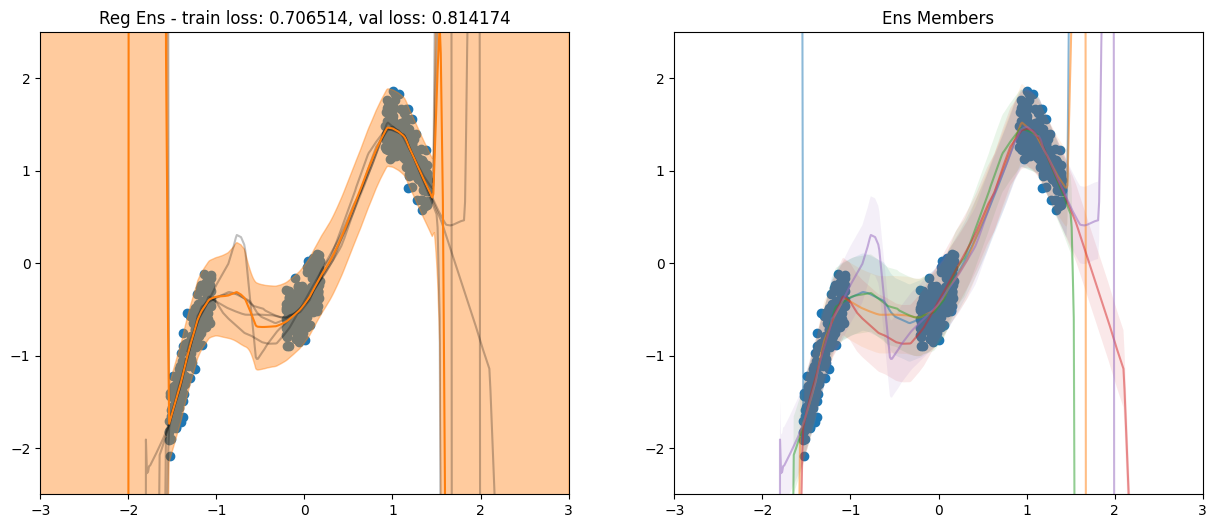

epoch: 231 - ('train loss: 0.68933, val loss: 0.79735, train err: 0.0311, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.68933')
epoch: 232 - ('train loss: 0.67219, val loss: 0.78085, train err: 0.0311, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.67219')
epoch: 233 - ('train loss: 0.65520, val loss: 0.76507, train err: 0.0311, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.65520')
epoch: 234 - ('train loss: 0.63821, val loss: 0.75194, train err: 0.0311, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.63821')
epoch: 235 - ('train loss: 0.62147, val loss: 0.74124, train err: 0.0311, val err: 0.0398, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.62147')
epoch: 236 - ('train loss: 0.60521, val loss: 0.72432, train err: 0.0311, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.60521')
epoch: 237 - ('train loss: 0.58925, val loss: 0.70652, train err: 0.0311, val err: 0.0396, lr: 0.000

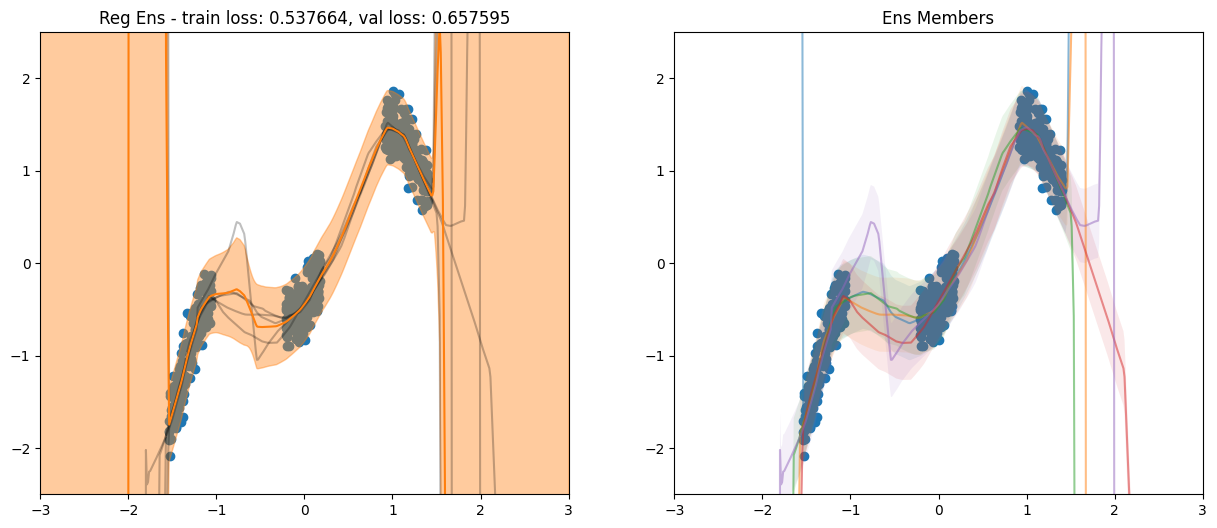

Best val_err
epoch: 241 - ('train loss: 0.52168, val loss: 0.64803, train err: 0.0311, val err: 0.0392, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.52168')
Best val_err
epoch: 242 - ('train loss: 0.50586, val loss: 0.63101, train err: 0.0311, val err: 0.0392, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.50586')
Best val_err
epoch: 243 - ('train loss: 0.48938, val loss: 0.61003, train err: 0.0311, val err: 0.0392, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.48938')
Best val_err
epoch: 244 - ('train loss: 0.47244, val loss: 0.59148, train err: 0.0311, val err: 0.0393, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.47244')
epoch: 245 - ('train loss: 0.45569, val loss: 0.57778, train err: 0.0311, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.45569')
epoch: 246 - ('train loss: 0.43938, val loss: 0.56448, train err: 0.0311, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.43938')
epoch: 247 - ('train loss: 0.42371, val loss: 0.

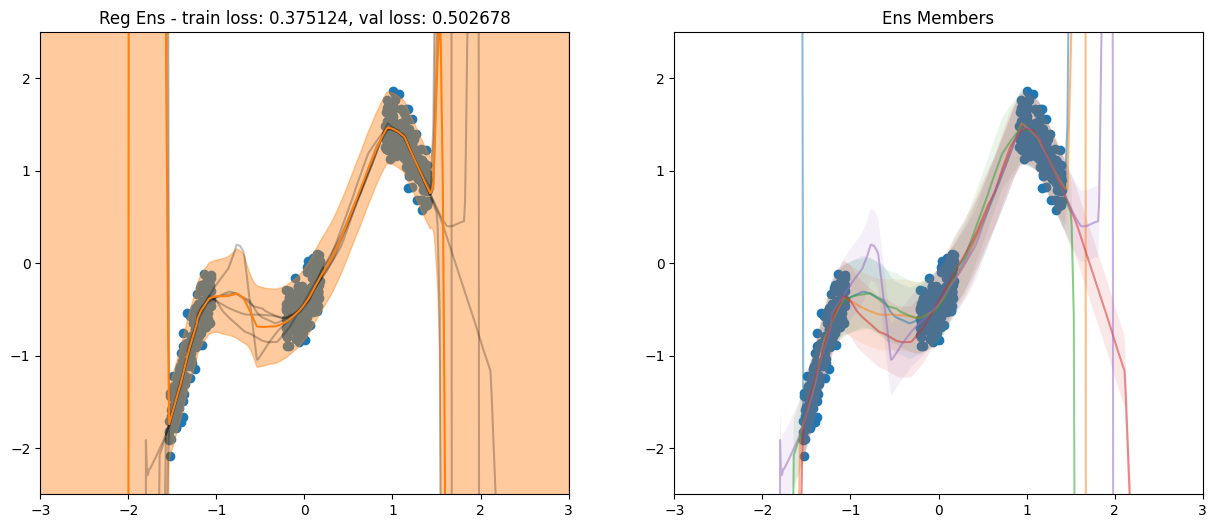

epoch: 251 - ('train loss: 0.35913, val loss: 0.48993, train err: 0.0311, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.35913')
epoch: 252 - ('train loss: 0.34335, val loss: 0.47452, train err: 0.0311, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.34335')
epoch: 253 - ('train loss: 0.32737, val loss: 0.45937, train err: 0.0311, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.32737')
epoch: 254 - ('train loss: 0.31167, val loss: 0.44502, train err: 0.0311, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.31167')
epoch: 255 - ('train loss: 0.29626, val loss: 0.43010, train err: 0.0311, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.29626')
epoch: 256 - ('train loss: 0.28045, val loss: 0.41667, train err: 0.0310, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.28045')
epoch: 257 - ('train loss: 0.26494, val loss: 0.40402, train err: 0.0311, val err: 0.0396, lr: 0.000

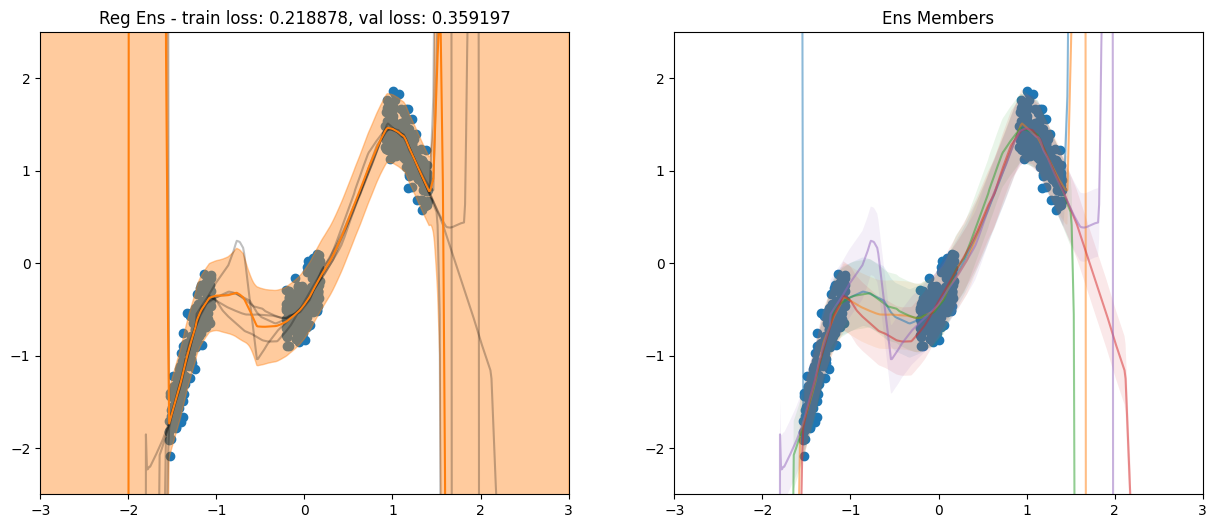

epoch: 261 - ('train loss: 0.20362, val loss: 0.34533, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.20362')
epoch: 262 - ('train loss: 0.18831, val loss: 0.33270, train err: 0.0310, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.18831')
epoch: 263 - ('train loss: 0.17316, val loss: 0.31964, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.17316')
epoch: 264 - ('train loss: 0.15831, val loss: 0.30932, train err: 0.0310, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.15831')
epoch: 265 - ('train loss: 0.14404, val loss: 0.29391, train err: 0.0311, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.14404')
epoch: 266 - ('train loss: 0.12884, val loss: 0.27787, train err: 0.0311, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.12884')
epoch: 267 - ('train loss: 0.11337, val loss: 0.26538, train err: 0.0310, val err: 0.0396, lr: 0.000

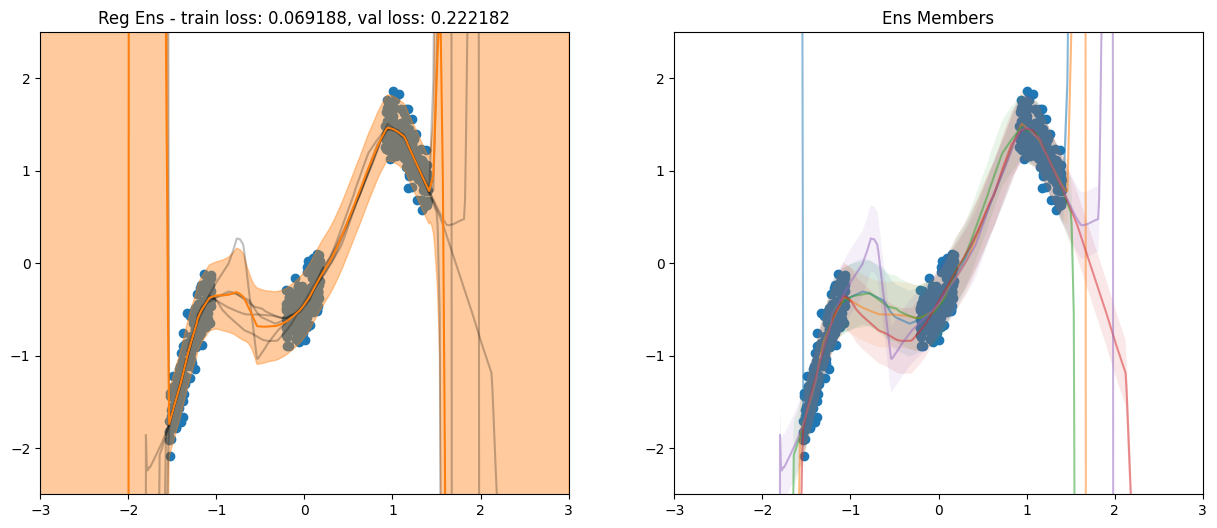

epoch: 271 - ('train loss: 0.05459, val loss: 0.21101, train err: 0.0310, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.05459')
epoch: 272 - ('train loss: 0.03992, val loss: 0.19850, train err: 0.0310, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.03992')
epoch: 273 - ('train loss: 0.02558, val loss: 0.18412, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.02558')
epoch: 274 - ('train loss: 0.01110, val loss: 0.16973, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: 0.01110')
epoch: 275 - ('train loss: -0.00315, val loss: 0.15602, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.00315')
epoch: 276 - ('train loss: -0.01739, val loss: 0.14450, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.01739')
epoch: 277 - ('train loss: -0.03163, val loss: 0.13354, train err: 0.0310, val err: 0.0395, lr: 

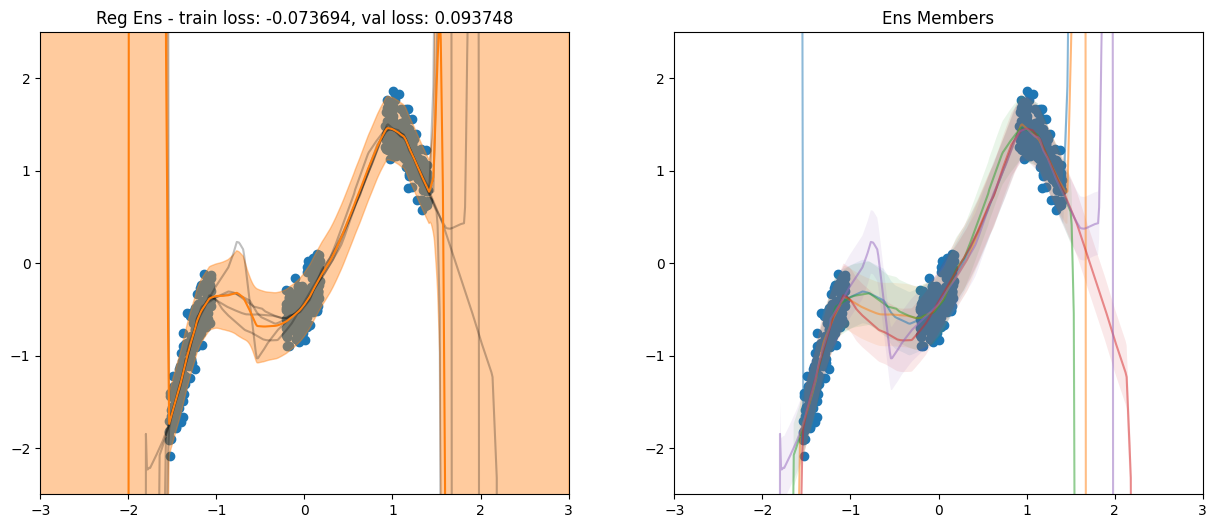

epoch: 281 - ('train loss: -0.08759, val loss: 0.08253, train err: 0.0310, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.08759')
epoch: 282 - ('train loss: -0.10139, val loss: 0.07090, train err: 0.0310, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.10139')
epoch: 283 - ('train loss: -0.11513, val loss: 0.05716, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.11513')
epoch: 284 - ('train loss: -0.12879, val loss: 0.04394, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.12879')
epoch: 285 - ('train loss: -0.14245, val loss: 0.03161, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.14245')
epoch: 286 - ('train loss: -0.15598, val loss: 0.02002, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.15598')
epoch: 287 - ('train loss: -0.16946, val loss: 0.00804, train err: 0.0310, val err: 0.03

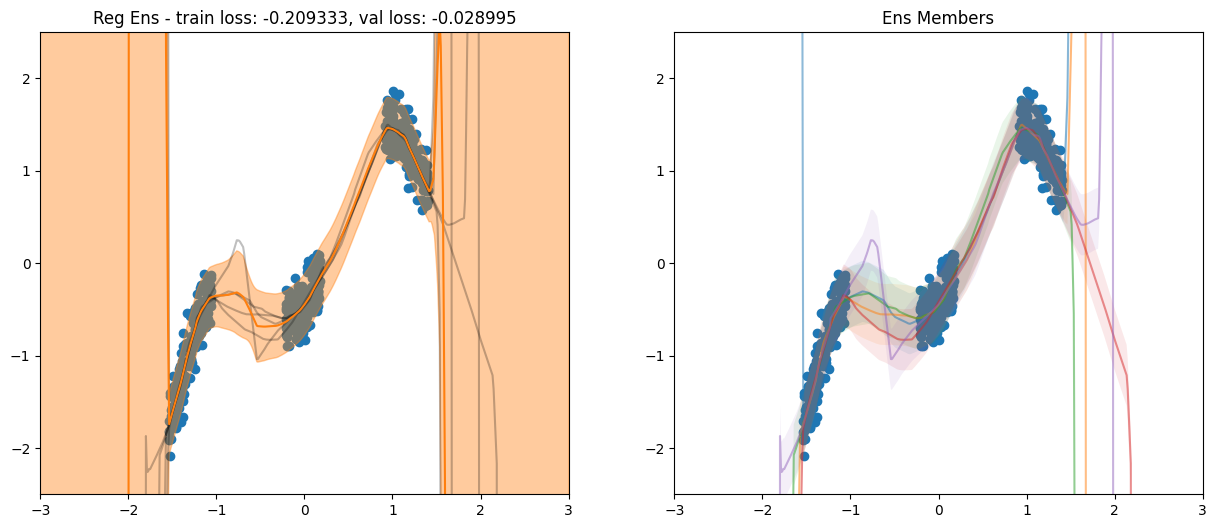

epoch: 291 - ('train loss: -0.22253, val loss: -0.04014, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.22253')
epoch: 292 - ('train loss: -0.23555, val loss: -0.05131, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.23555')
epoch: 293 - ('train loss: -0.24864, val loss: -0.06349, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.24864')
epoch: 294 - ('train loss: -0.26154, val loss: -0.07557, train err: 0.0310, val err: 0.0393, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.26154')
epoch: 295 - ('train loss: -0.27442, val loss: -0.08664, train err: 0.0310, val err: 0.0393, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.27442')
epoch: 296 - ('train loss: -0.28717, val loss: -0.09684, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.28717')
epoch: 297 - ('train loss: -0.29993, val loss: -0.10785, train err: 0.0310, val er

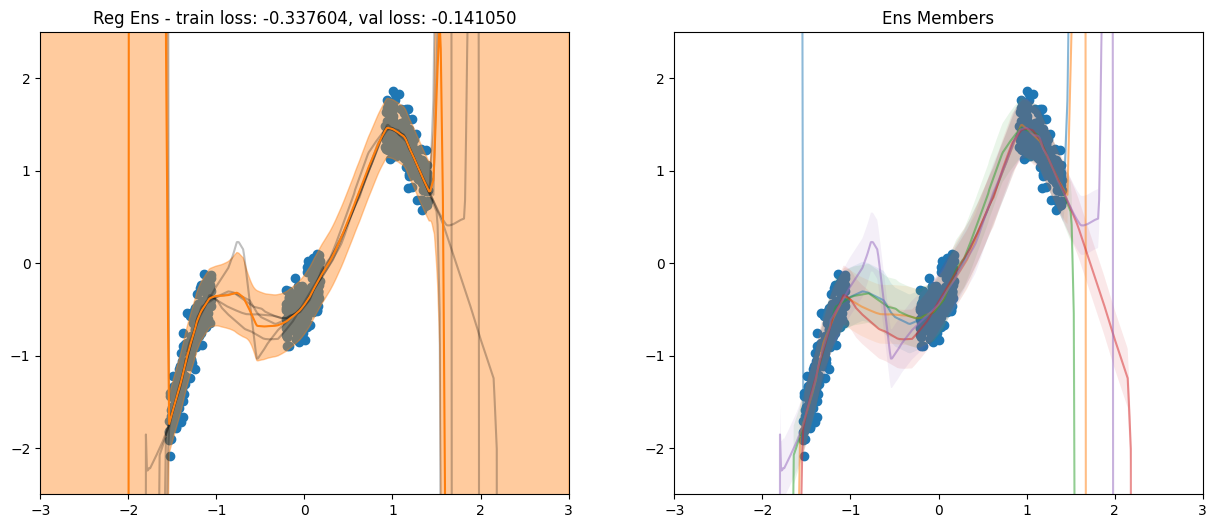

epoch: 301 - ('train loss: -0.35002, val loss: -0.15087, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.35002')
epoch: 302 - ('train loss: -0.36233, val loss: -0.16230, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.36233')
epoch: 303 - ('train loss: -0.37465, val loss: -0.17386, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.37465')
epoch: 304 - ('train loss: -0.38686, val loss: -0.18462, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.38686')
epoch: 305 - ('train loss: -0.39900, val loss: -0.19411, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.39900')
epoch: 306 - ('train loss: -0.41103, val loss: -0.20419, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.41103')
epoch: 307 - ('train loss: -0.42304, val loss: -0.21557, train err: 0.0310, val er

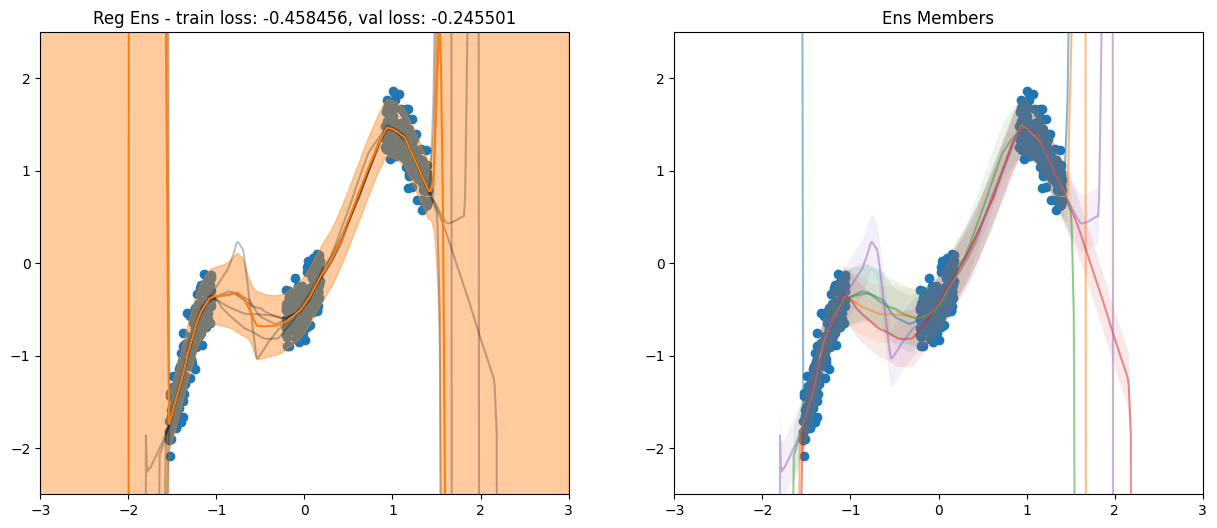

epoch: 311 - ('train loss: -0.47019, val loss: -0.25604, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.47019')
epoch: 312 - ('train loss: -0.48168, val loss: -0.26659, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.48168')
epoch: 313 - ('train loss: -0.49330, val loss: -0.27597, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.49330')
epoch: 314 - ('train loss: -0.50468, val loss: -0.28517, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.50468')
epoch: 315 - ('train loss: -0.51606, val loss: -0.29536, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.51606')
epoch: 316 - ('train loss: -0.52742, val loss: -0.30594, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.52742')
epoch: 317 - ('train loss: -0.53861, val loss: -0.31491, train err: 0.0310, val er

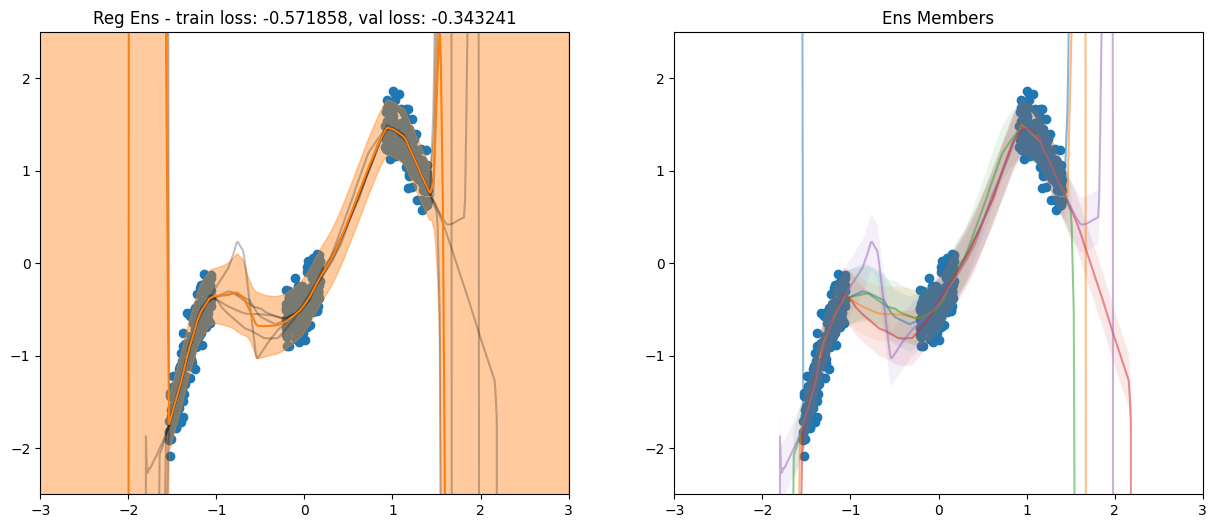

epoch: 321 - ('train loss: -0.58276, val loss: -0.35206, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.58276')
epoch: 322 - ('train loss: -0.59359, val loss: -0.35988, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.59359')
epoch: 323 - ('train loss: -0.60435, val loss: -0.36897, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.60435')
epoch: 324 - ('train loss: -0.61512, val loss: -0.37885, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.61512')
epoch: 325 - ('train loss: -0.62552, val loss: -0.38778, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.62552')
epoch: 326 - ('train loss: -0.63623, val loss: -0.39464, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.63623')
epoch: 327 - ('train loss: -0.64655, val loss: -0.39742, train err: 0.0310, val er

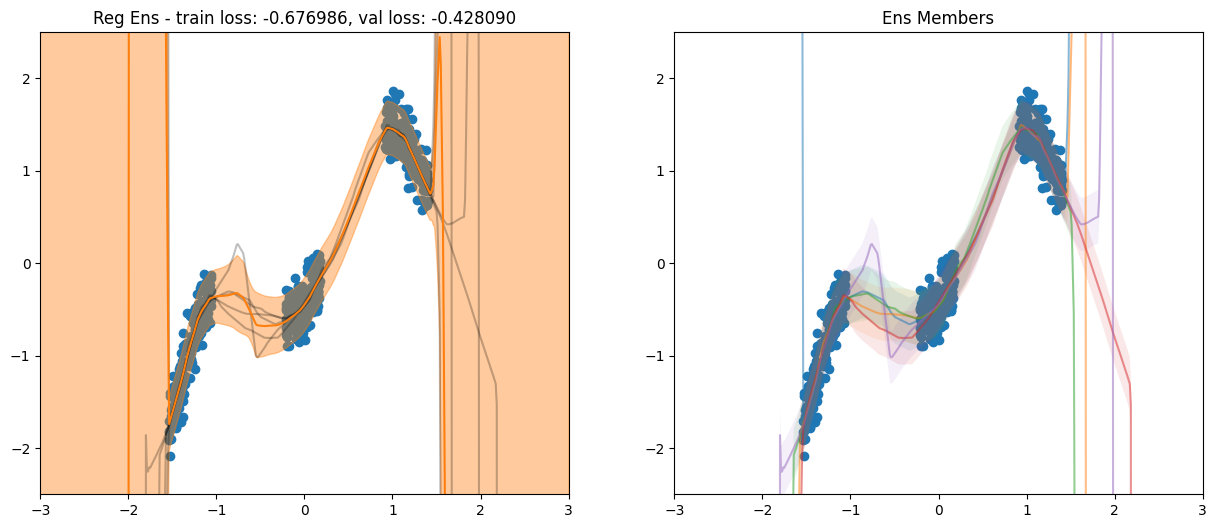

epoch: 331 - ('train loss: -0.68741, val loss: -0.42670, train err: 0.0310, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.68741')
epoch: 332 - ('train loss: -0.69681, val loss: -0.44883, train err: 0.0310, val err: 0.0393, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.69681')
epoch: 333 - ('train loss: -0.70718, val loss: -0.46019, train err: 0.0310, val err: 0.0392, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.70718')
epoch: 334 - ('train loss: -0.71711, val loss: -0.45587, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.71711')
epoch: 335 - ('train loss: -0.72656, val loss: -0.44524, train err: 0.0310, val err: 0.0397, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.72656')
epoch: 336 - ('train loss: -0.73408, val loss: -0.47482, train err: 0.0310, val err: 0.0393, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.73408')
epoch: 337 - ('train loss: -0.74548, val loss: -0.48654, train err: 0.0310, val er

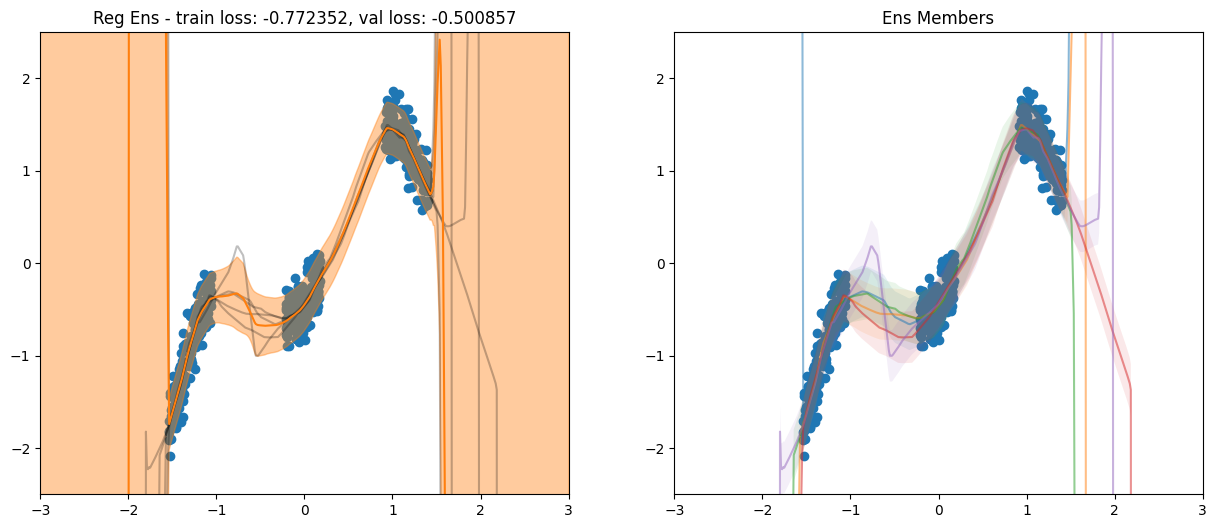

epoch: 341 - ('train loss: -0.78433, val loss: -0.51563, train err: 0.0310, val err: 0.0393, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.78433')
epoch: 342 - ('train loss: -0.79233, val loss: -0.52150, train err: 0.0310, val err: 0.0393, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.79233')
epoch: 343 - ('train loss: -0.80113, val loss: -0.52614, train err: 0.0310, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.80113')
epoch: 344 - ('train loss: -0.81135, val loss: -0.54618, train err: 0.0310, val err: 0.0393, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.81135')
epoch: 345 - ('train loss: -0.82228, val loss: -0.55131, train err: 0.0310, val err: 0.0391, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.82228')
Best val_err
epoch: 346 - ('train loss: -0.83016, val loss: -0.55474, train err: 0.0310, val err: 0.0391, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.83016')
Best val_err
epoch: 347 - ('train loss: -0.83808, val loss: -0.56695,

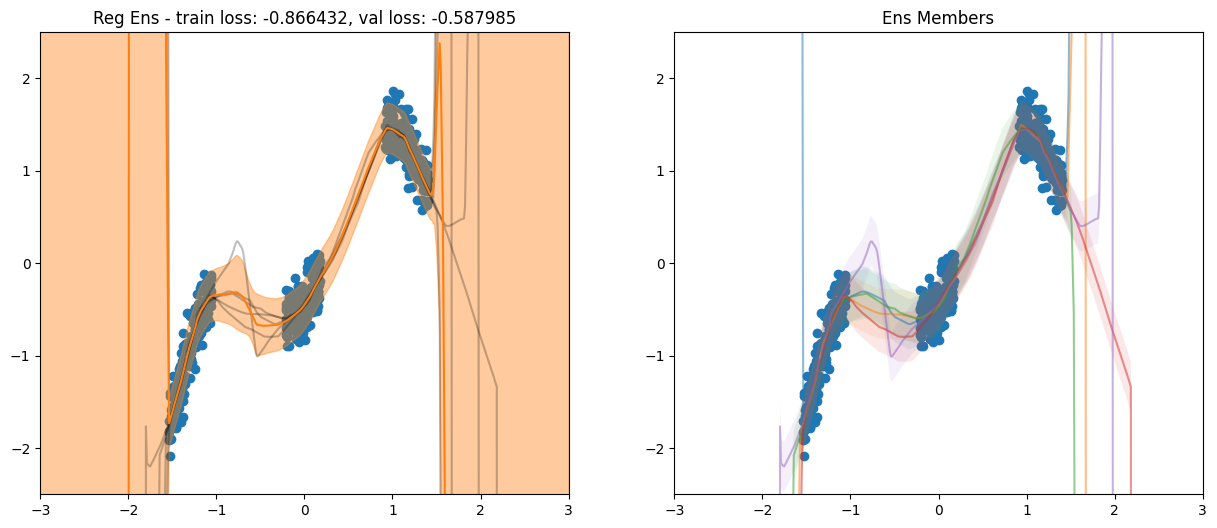

epoch: 351 - ('train loss: -0.87469, val loss: -0.59488, train err: 0.0310, val err: 0.0392, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.87469')
epoch: 352 - ('train loss: -0.88320, val loss: -0.59820, train err: 0.0310, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.88320')
epoch: 353 - ('train loss: -0.89206, val loss: -0.60956, train err: 0.0310, val err: 0.0393, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.89206')
epoch: 354 - ('train loss: -0.90093, val loss: -0.61565, train err: 0.0310, val err: 0.0392, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.90093')
epoch: 355 - ('train loss: -0.90858, val loss: -0.61233, train err: 0.0310, val err: 0.0392, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.90858')
epoch: 356 - ('train loss: -0.91491, val loss: -0.62579, train err: 0.0310, val err: 0.0393, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.91491')
epoch: 357 - ('train loss: -0.92511, val loss: -0.63559, train err: 0.0310, val er

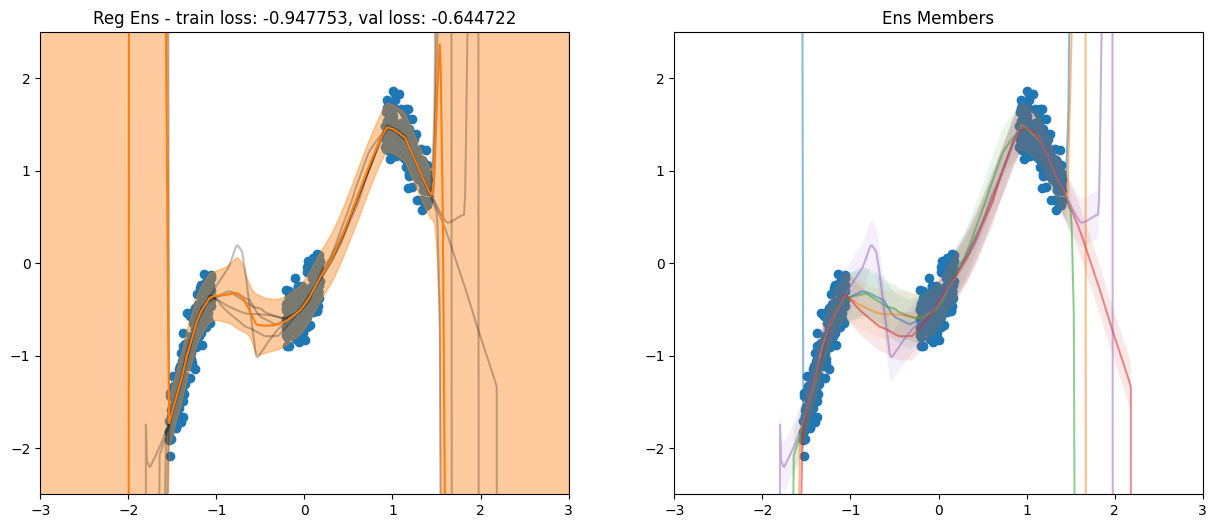

epoch: 361 - ('train loss: -0.95688, val loss: -0.65810, train err: 0.0310, val err: 0.0391, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.95688')
epoch: 362 - ('train loss: -0.96505, val loss: -0.65205, train err: 0.0310, val err: 0.0391, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.96505')
epoch: 363 - ('train loss: -0.97109, val loss: -0.66405, train err: 0.0310, val err: 0.0392, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.97109')
epoch: 364 - ('train loss: -0.97942, val loss: -0.67649, train err: 0.0310, val err: 0.0393, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.97942')
epoch: 365 - ('train loss: -0.98841, val loss: -0.67342, train err: 0.0309, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.98841')
epoch: 366 - ('train loss: -0.99631, val loss: -0.66890, train err: 0.0309, val err: 0.0397, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -0.99631')
epoch: 367 - ('train loss: -1.00194, val loss: -0.68889, train err: 0.0309, val er

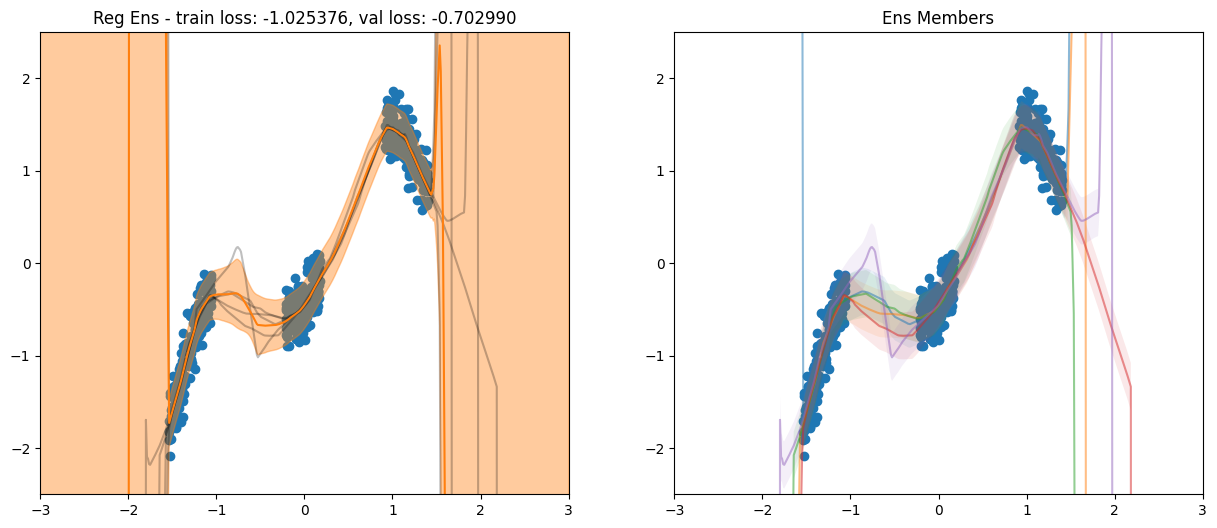

epoch: 371 - ('train loss: -1.03258, val loss: -0.70258, train err: 0.0309, val err: 0.0395, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -1.03258')
epoch: 372 - ('train loss: -1.03773, val loss: -0.72310, train err: 0.0310, val err: 0.0391, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -1.03773')
Best val_err
epoch: 373 - ('train loss: -1.04721, val loss: -0.71561, train err: 0.0309, val err: 0.0390, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -1.04721')
Best val_err
epoch: 374 - ('train loss: -1.05266, val loss: -0.72259, train err: 0.0310, val err: 0.0391, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -1.05266')
epoch: 375 - ('train loss: -1.05982, val loss: -0.73670, train err: 0.0310, val err: 0.0392, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -1.05982')
epoch: 376 - ('train loss: -1.06826, val loss: -0.73273, train err: 0.0309, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -1.06826')
epoch: 377 - ('train loss: -1.07458, val loss: -0.72619,

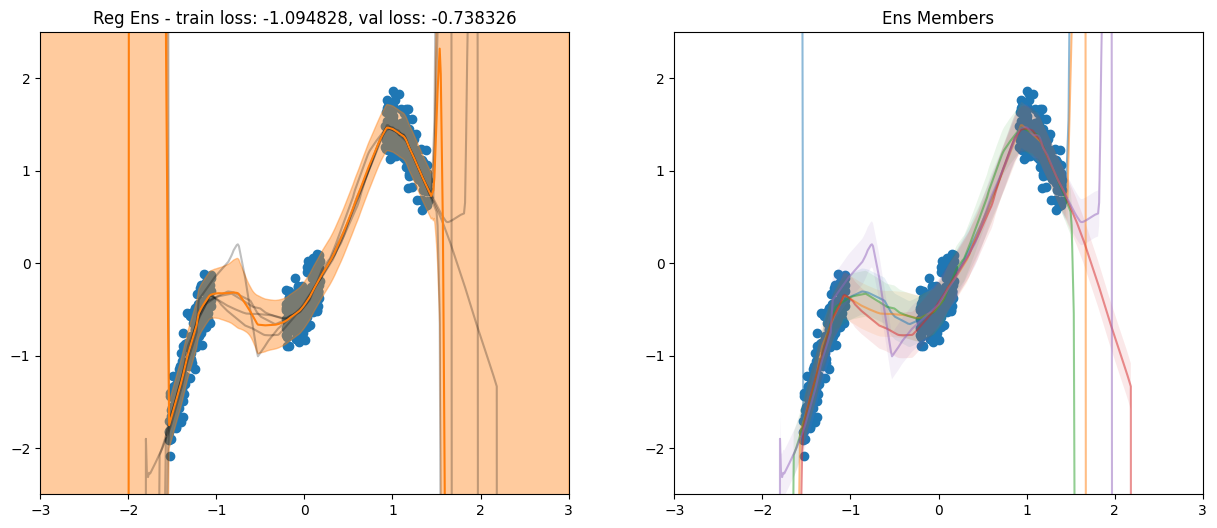

epoch: 381 - ('train loss: -1.09919, val loss: -0.75671, train err: 0.0310, val err: 0.0391, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -1.09919')
epoch: 382 - ('train loss: -1.10759, val loss: -0.76987, train err: 0.0309, val err: 0.0392, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -1.10759')
epoch: 383 - ('train loss: -1.11565, val loss: -0.76459, train err: 0.0309, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -1.11565')
epoch: 384 - ('train loss: -1.12037, val loss: -0.77396, train err: 0.0309, val err: 0.0393, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -1.12037')
epoch: 385 - ('train loss: -1.12722, val loss: -0.78517, train err: 0.0309, val err: 0.0391, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -1.12722')
epoch: 386 - ('train loss: -1.13448, val loss: -0.78605, train err: 0.0309, val err: 0.0390, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -1.13448')
epoch: 387 - ('train loss: -1.14024, val loss: -0.79154, train err: 0.0309, val er

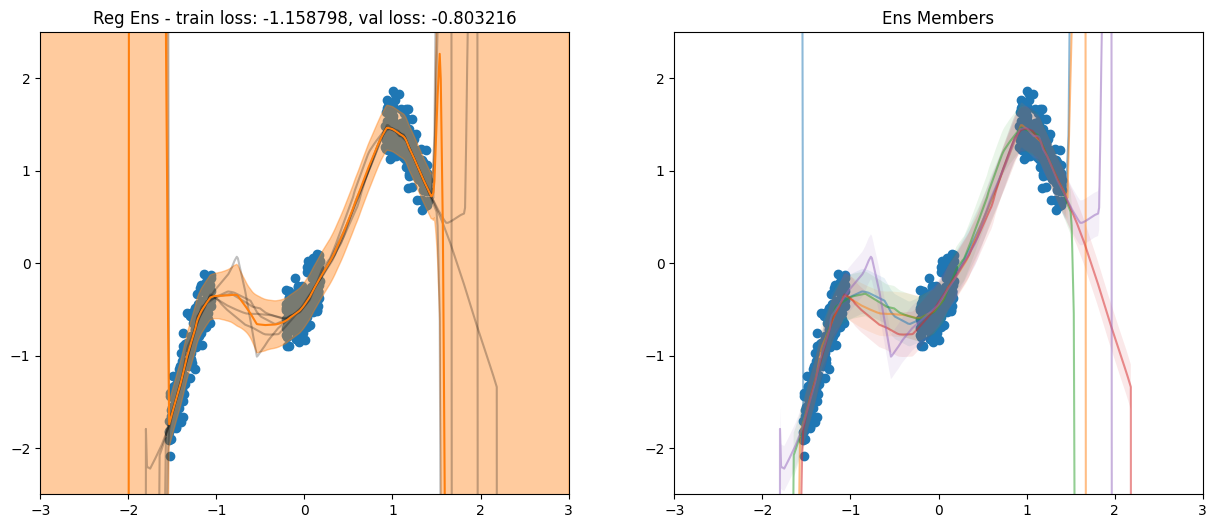

epoch: 391 - ('train loss: -1.16480, val loss: -0.80883, train err: 0.0309, val err: 0.0393, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -1.16480')
epoch: 392 - ('train loss: -1.17089, val loss: -0.81362, train err: 0.0309, val err: 0.0392, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -1.17089')
epoch: 393 - ('train loss: -1.17620, val loss: -0.81835, train err: 0.0309, val err: 0.0392, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -1.17620')
epoch: 394 - ('train loss: -1.18214, val loss: -0.81657, train err: 0.0309, val err: 0.0393, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -1.18214')
epoch: 395 - ('train loss: -1.18775, val loss: -0.79103, train err: 0.0309, val err: 0.0396, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -1.18775')
epoch: 396 - ('train loss: -1.19034, val loss: -0.80148, train err: 0.0309, val err: 0.0394, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -1.19034')
epoch: 397 - ('train loss: -1.19561, val loss: -0.82079, train err: 0.0309, val er

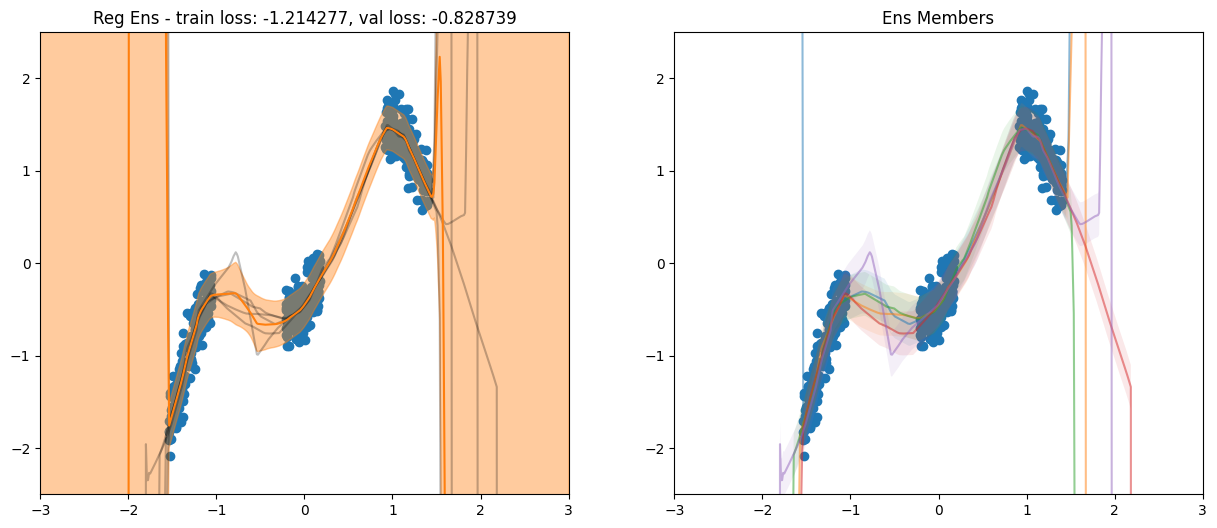

epoch: 401 - ('train loss: -1.21907, val loss: -0.84700, train err: 0.0309, val err: 0.0391, lr: 0.00010, prod_nll: 1.00000', ', members_nll: -1.21907')


In [46]:
config = get_reg_ens_config()

data_gen_fn = getattr(src.data, config.dataset_name)
train_dataset, test_dataset, val_dataset = data_gen_fn(**config.dataset.to_dict())
train_loader = NumpyLoader(train_dataset, config.batch_size)
val_loader = NumpyLoader(val_dataset, config.batch_size)
test_loader = NumpyLoader(test_dataset, config.batch_size)

init_x = train_dataset[0][0]
init_y = train_dataset[0][1]


best_ens_states = []
for i in range(1):
    rng = random.PRNGKey(i)

    setup_rng, rng = random.split(rng)
    config.epochs = 401

    ens_model, state = setup_training(config, setup_rng, init_x, init_y)

    if ENS_RETRAIN:  # RETRAIN
        state, best_state = train_loop(
            ens_model, state, config, rng, make_Reg_Ens_loss, make_Reg_Ens_loss, train_loader, val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'online',
                # 'notes': '',
            },
            plot_fn=make_Reg_Ens_plots,
        )

        best_ens_states.append(best_state)

        save_checkpoint(f'dynNN_results/ens_model_{i}', best_ens_states, 1, overwrite=True)

## 3. Metrics

In [14]:
X_test, y_test = list(zip(*test_loader.dataset))

In [15]:
def get_metrics(models):
    results_df = pd.DataFrame(columns=['model_name', 'n_members', 'random_seed', 'H', 'mse', 'nll'])
    
    s = set(range(5))
    power_set = sum(map(lambda r: list(combinations(s, r)), range(1, len(s)+1)), [])

    for model_name in models:
        for i in range(1):
            print(model_name)
            
            if "pog" in model_name:
                model_type = pog_model
                state = restore_checkpoint(f'dynNN_results/{model_name}', 1)
            elif "ens" in model_name:
                model_type = ens_model
                state = restore_checkpoint(f'dynNN_results/{model_name}', 1)["0"]

            pred_fun = partial(
                model_type.apply,
                {"params": state['params'], **state['model_state']},
                train=False, return_ens_preds=True,
                method=model_type.pred
            )
            _, (locs, scales) = jax.vmap(
                pred_fun, out_axes=(0, 1), in_axes=(0,), axis_name="batch"
            )(jnp.array(X_test))

            for indices in power_set:
                n_members = len(indices)

                if 'pog' in model_name:
                    loc, scale = calculate_pog_loc_scale(locs[indices, :, 0], scales[indices, :, 0])
                    entropies = jax.vmap(uniform_entropy)(loc, scale)
                    nlls_ = jax.vmap(uniform_nll)(loc, scale, jnp.array(y_test))
                    infs = jnp.isinf(nlls_)
                    print(f"dropping {infs.sum()} infs for prod of {n_members}")
                    nlls = nlls_[~infs]
                elif 'ens' in model_name:
                    loc, scale = calculate_ens_loc_scale(locs[indices, :, 0], scales[indices, :, 0], 1/n_members)
                    entropies = jax.vmap(normal_entropy)(loc, scale)
                    nlls = jax.vmap(normal_nll)(loc, scale, jnp.array(y_test))
                else:
                    raise ValueError()

                errors = jax.vmap(mse)(loc, jnp.array(y_test))

                results_df = pd.concat([
                    results_df,
                    pd.DataFrame({
                        'model_name': [model_name],
                        'n_members': [n_members],
                        'random_seed': [i],
                        'H': [entropies.mean()],
                        'nll': [nlls.mean()],
                        'mse': [errors.mean()],
                    })],
                    ignore_index=True
                )
                
    min_mse_df = results_df[results_df.n_members == 5][['model_name', 'random_seed', 'mse', 'nll']].rename(
    columns={'mse': 'final_mse', 'nll': 'final_nll'}
)
    tmp_df = results_df.merge(min_mse_df, on=['model_name', 'random_seed'], how='left')
    tmp_df['mse_diff'] = tmp_df['mse'] - tmp_df['final_mse'] 
    tmp_df['nll_diff'] = tmp_df['nll'] - tmp_df['final_nll'] 
    
    agg_df = tmp_df.groupby(by=['model_name', 'n_members']).agg({
    'H': ['mean', 'std', 'count'],
    'mse_diff': ['mean', 'std', 'count'],
    'mse': ['mean', 'std', 'count'],
    'nll_diff': ['mean', 'std', 'count'],
    'nll': ['mean', 'std', 'count'],
})
    agg_df[('H', 'std_err')] = agg_df[('H', 'std')] / agg_df[('H', 'count')]
    agg_df[('mse_diff', 'std_err')] = agg_df[('mse_diff', 'std')] / agg_df[('mse_diff', 'count')]
    agg_df[('mse', 'std_err')] = agg_df[('mse', 'std')] / agg_df[('mse', 'count')]
    agg_df[('nll_diff', 'std_err')] = agg_df[('nll_diff', 'std')] / agg_df[('nll_diff', 'count')]
    agg_df[('nll', 'std_err')] = agg_df[('nll', 'std')] / agg_df[('nll', 'count')]
    
    return agg_df

In [16]:
def generate_name(model_type, i, members_ll, alpha, beta):
    members_ll = members_ll if members_ll else ""
    alpha = alpha if alpha is not None else ""
    beta = beta if beta is not None else ""
    return f"{model_type}_model_{i}_{members_ll}_{alpha}_{beta}".rstrip("_")

## 4) experiments

##  main findings:

- plot 1: having $w_M$ in PoE hurts performance, since we are multiplying gradients with e.g. 0.2, so it takes longer for model to converge
- plot 2: aligning distributions between product and DE terms in objective function does not fully close the performance gap (contrary to the classification case)
- plot 3: 
    - as we increasing the "importance" of the product term in the objective function, the performance of individual base learners gets worse. 
    - for alpha=1 PoE is equivalent to DE with GNDs. it is encouracing to see that the performance is similar to a DE of Gaussians, meaning we are not losing too much performance due to working with GNDs

### plot 1

In [72]:
models = ["pog_model_0_GND_1.0_16_tempered", "pog_model_0_GND_1.0_16_tempered_1000_epochs", "pog_model_0_GND_1.0_16", "pog_model_0_gaussian_1.0_16", "ens_model_0", "ens_model_0_400_epochs"]

In [73]:
metrics_df = get_metrics(models)

pog_model_0_GND_1.0_16_tempered
dropping 0 infs for prod of 1
dropping 0 infs for prod of 1
dropping 1 infs for prod of 1
dropping 0 infs for prod of 1
dropping 0 infs for prod of 1
dropping 0 infs for prod of 2
dropping 1 infs for prod of 2
dropping 0 infs for prod of 2
dropping 0 infs for prod of 2
dropping 1 infs for prod of 2
dropping 0 infs for prod of 2
dropping 0 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 0 infs for prod of 2
dropping 1 infs for prod of 3
dropping 0 infs for prod of 3
dropping 0 infs for prod of 3
dropping 1 infs for prod of 3
dropping 1 infs for prod of 3
dropping 0 infs for prod of 3
dropping 1 infs for prod of 3
dropping 1 infs for prod of 3
dropping 0 infs for prod of 3
dropping 1 infs for prod of 3
dropping 1 infs for prod of 4
dropping 1 infs for prod of 4
dropping 0 infs for prod of 4
dropping 1 infs for prod of 4
dropping 1 infs for prod of 4
dropping 1 infs for prod of 5
pog_model_0_GND_1.0_16_tempered_1000_e

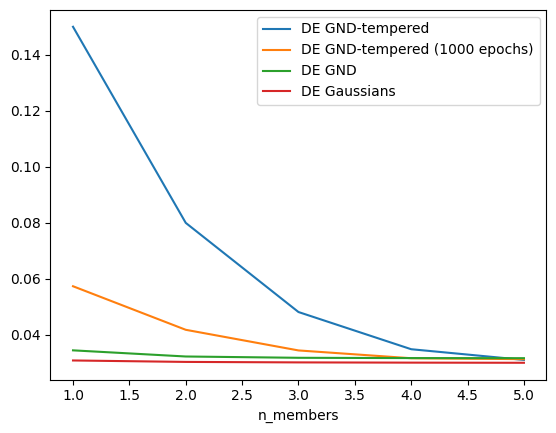

In [76]:
METRIC = "mse"
model_name = f'pog_model_0_GND_1.0_16_tempered'
metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                   label="DE GND-tempered", 
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
model_name = f'pog_model_0_GND_1.0_16_tempered_1000_epochs'
metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                   label="DE GND-tempered (1000 epochs)", 
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
model_name = f'pog_model_0_GND_1.0_16'
metrics_df[METRIC]["mean"].loc[model_name, :].plot(label="DE GND"
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(label="DE Gaussians"
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
plt.legend()
plt.show()

### plot 2

In [77]:
BETA_END = [2, 8 ,16]
ALPHAS = [0., 0.5, 1.]

In [78]:
models = [generate_name("ens", 0, None, None, None)] + [generate_name("pog", 0, members_ll, alpha, beta) for alpha in ALPHAS for beta in BETA_END for members_ll in [MEMBERS_LL.GND.value, MEMBERS_LL.gaussian.value]]
models

['ens_model_0',
 'pog_model_0_GND_0.0_2',
 'pog_model_0_gaussian_0.0_2',
 'pog_model_0_GND_0.0_8',
 'pog_model_0_gaussian_0.0_8',
 'pog_model_0_GND_0.0_16',
 'pog_model_0_gaussian_0.0_16',
 'pog_model_0_GND_0.5_2',
 'pog_model_0_gaussian_0.5_2',
 'pog_model_0_GND_0.5_8',
 'pog_model_0_gaussian_0.5_8',
 'pog_model_0_GND_0.5_16',
 'pog_model_0_gaussian_0.5_16',
 'pog_model_0_GND_1.0_2',
 'pog_model_0_gaussian_1.0_2',
 'pog_model_0_GND_1.0_8',
 'pog_model_0_gaussian_1.0_8',
 'pog_model_0_GND_1.0_16',
 'pog_model_0_gaussian_1.0_16']

In [79]:
metrics_df = get_metrics(models)

ens_model_0
pog_model_0_GND_0.0_2
dropping 79 infs for prod of 1
dropping 45 infs for prod of 1
dropping 64 infs for prod of 1
dropping 105 infs for prod of 1
dropping 26 infs for prod of 1
dropping 103 infs for prod of 2
dropping 23 infs for prod of 2
dropping 68 infs for prod of 2
dropping 71 infs for prod of 2
dropping 47 infs for prod of 2
dropping 35 infs for prod of 2
dropping 71 infs for prod of 2
dropping 72 infs for prod of 2
dropping 13 infs for prod of 2
dropping 54 infs for prod of 2
dropping 58 infs for prod of 3
dropping 29 infs for prod of 3
dropping 104 infs for prod of 3
dropping 9 infs for prod of 3
dropping 23 infs for prod of 3
dropping 50 infs for prod of 3
dropping 32 infs for prod of 3
dropping 48 infs for prod of 3
dropping 32 infs for prod of 3
dropping 14 infs for prod of 3
dropping 0 infs for prod of 4
dropping 58 infs for prod of 4
dropping 30 infs for prod of 4
dropping 3 infs for prod of 4
dropping 9 infs for prod of 4
dropping 0 infs for prod of 5
pog_mod

dropping 6 infs for prod of 3
dropping 6 infs for prod of 3
dropping 6 infs for prod of 3
dropping 1 infs for prod of 3
dropping 3 infs for prod of 3
dropping 3 infs for prod of 3
dropping 3 infs for prod of 3
dropping 6 infs for prod of 4
dropping 6 infs for prod of 4
dropping 6 infs for prod of 4
dropping 6 infs for prod of 4
dropping 3 infs for prod of 4
dropping 6 infs for prod of 5
pog_model_0_gaussian_0.5_8
dropping 3 infs for prod of 1
dropping 0 infs for prod of 1
dropping 1 infs for prod of 1
dropping 0 infs for prod of 1
dropping 1 infs for prod of 1
dropping 3 infs for prod of 2
dropping 4 infs for prod of 2
dropping 3 infs for prod of 2
dropping 4 infs for prod of 2
dropping 1 infs for prod of 2
dropping 0 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 2 infs for prod of 2
dropping 1 infs for prod of 2
dropping 4 infs for prod of 3
dropping 3 infs for prod of 3
dropping 4 infs for prod of 3
dropping 4 infs for prod of 3
dropping 5 in

dropping 0 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 0 infs for prod of 2
dropping 2 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 2
dropping 1 infs for prod of 3
dropping 1 infs for prod of 3
dropping 0 infs for prod of 3
dropping 2 infs for prod of 3
dropping 1 infs for prod of 3
dropping 1 infs for prod of 3
dropping 2 infs for prod of 3
dropping 1 infs for prod of 3
dropping 1 infs for prod of 3
dropping 2 infs for prod of 3
dropping 2 infs for prod of 4
dropping 1 infs for prod of 4
dropping 1 infs for prod of 4
dropping 2 infs for prod of 4
dropping 2 infs for prod of 4
dropping 2 infs for prod of 5


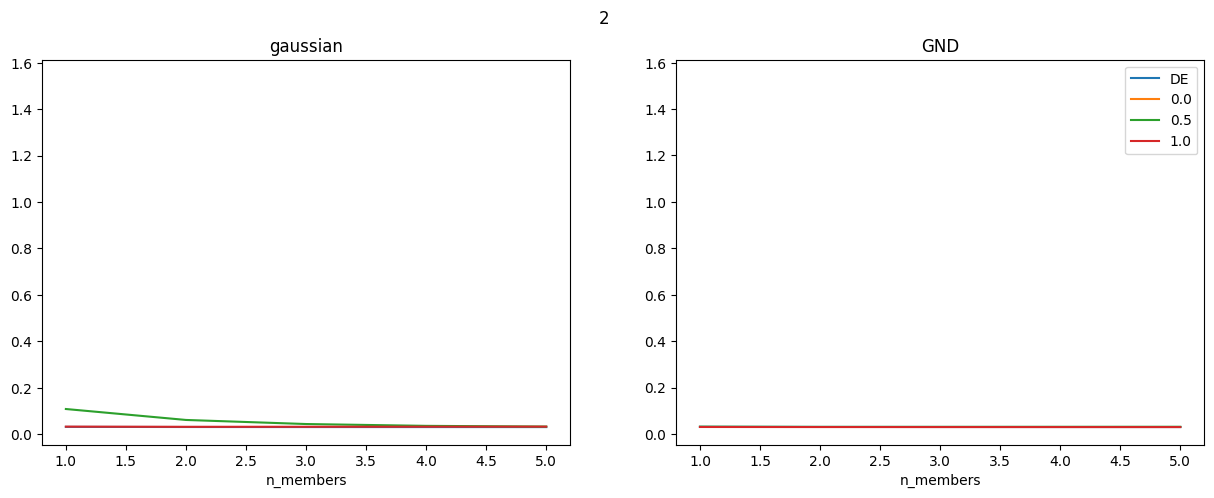

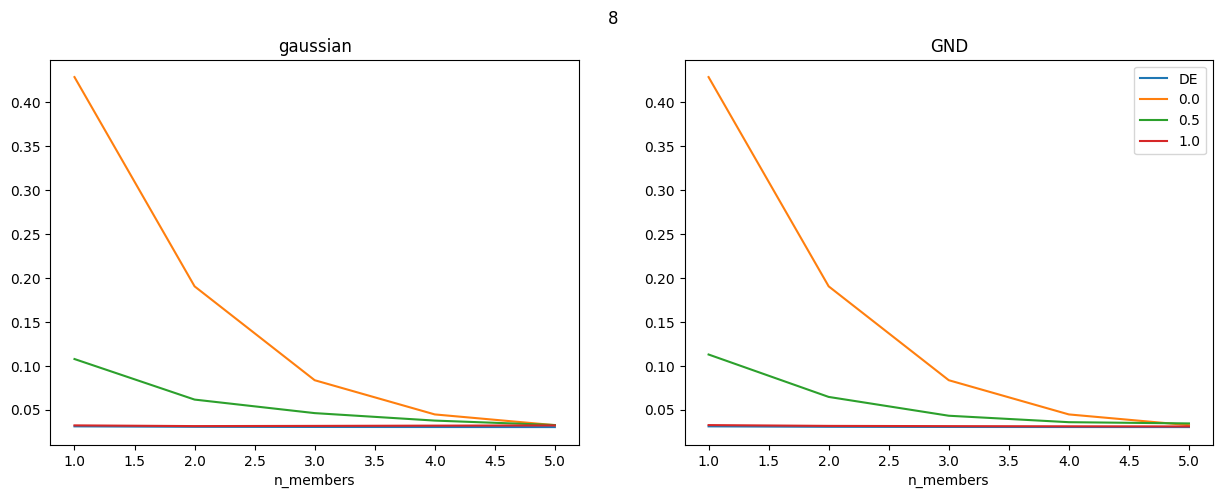

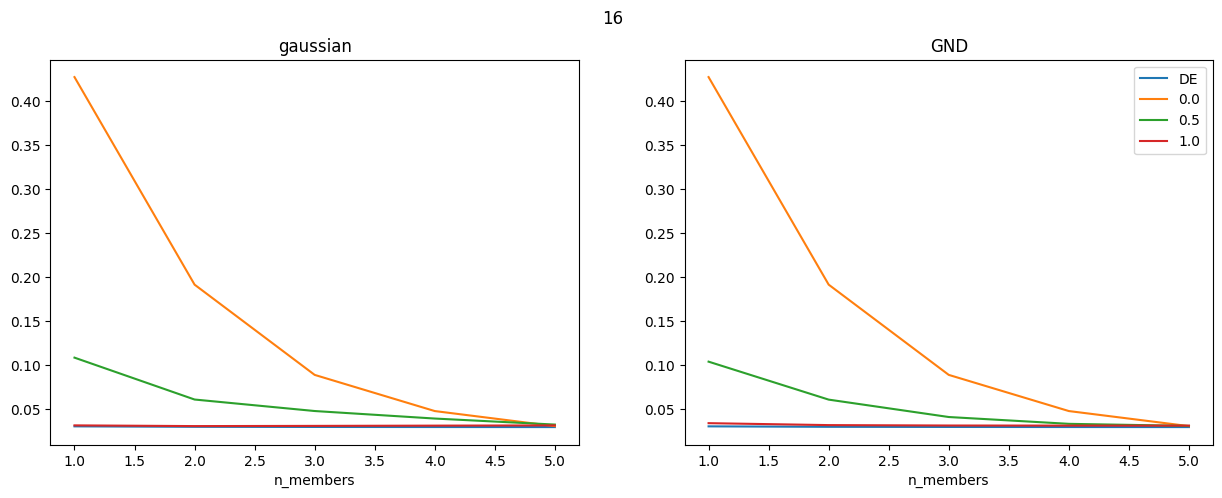

In [81]:
METRIC = "mse"
for beta in BETA_END:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(ax=axes[0], label="DE")
    metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(ax=axes[1], label="DE")

    # alpha_plot = np.linspace(0.2, 0.9, len(ALPHAS))
    for i, alpha in enumerate(ALPHAS):
         #if alpha == 0.5:
        model_name = f'pog_model_0_{MEMBERS_LL.gaussian.value}_{alpha}_{beta}'
        metrics_df[METRIC]["mean"].loc[model_name, :].plot(
                                                           ax=axes[0], 
                                                           label=alpha, 
                                                           # color="red", 
                                                           # alpha=alpha_plot[i]
                                                            )
        model_name = f'pog_model_0_{MEMBERS_LL.GND.value}_{alpha}_{beta}'
        metrics_df[METRIC]["mean"].loc[model_name, :].plot(
                                                           ax=axes[1], 
                                                           label=alpha, 
                                                           # color="red", 
                                                           # alpha=alpha_plot[i]
                                                            )

    axes[1].set_title(MEMBERS_LL.GND.value)
    axes[0].set_title(MEMBERS_LL.gaussian.value)
    
    fig.suptitle(beta)
    plt.legend()
    plt.show()

### plot 3

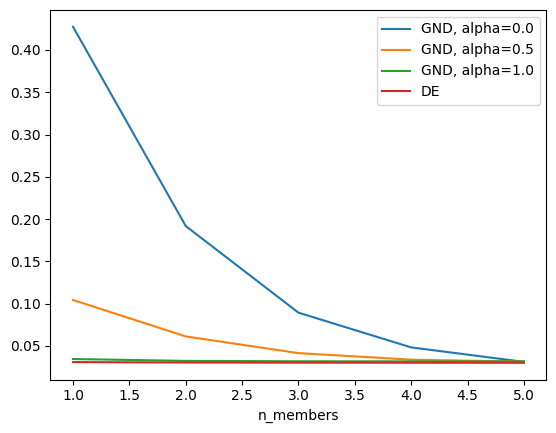

In [84]:
METRIC = "mse"
model_name = f'pog_model_0_{MEMBERS_LL.GND.value}_{0.0}_{16}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                   label=f"{MEMBERS_LL.GND.value}, alpha={0.0}", 
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
model_name = f'pog_model_0_{MEMBERS_LL.GND.value}_{0.5}_{16}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                   label=f"{MEMBERS_LL.GND.value}, alpha={0.5}",
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
model_name = f'pog_model_0_{MEMBERS_LL.GND.value}_{1.0}_{16}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                   label=f"{MEMBERS_LL.GND.value}, alpha={1.0}",
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(label="DE"
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
plt.legend()
plt.show()

## TODO:
- compare magnitudes of product and DE term (see if product term is dominating the DE term)
- try pretraining base learners and only bring in product term in the finetunign phase

### why is there a difference for alpha=1.0 (so we ignore product term completely) and beta=2? isn't for beta=2 GND supposed to be equal to gaussian?

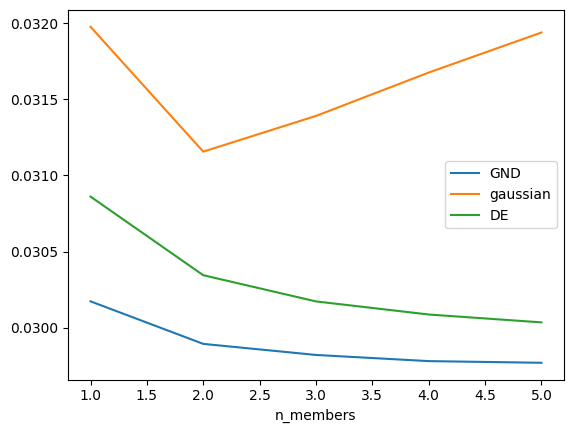

In [82]:
METRIC = "mse"
model_name = f'pog_model_0_{MEMBERS_LL.GND.value}_{1.0}_{2}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                   label=MEMBERS_LL.GND.value, 
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
model_name = f'pog_model_0_{MEMBERS_LL.gaussian.value}_{1.0}_{2}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot(label=MEMBERS_LL.gaussian.value
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(label="DE"
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
plt.legend()
plt.show()

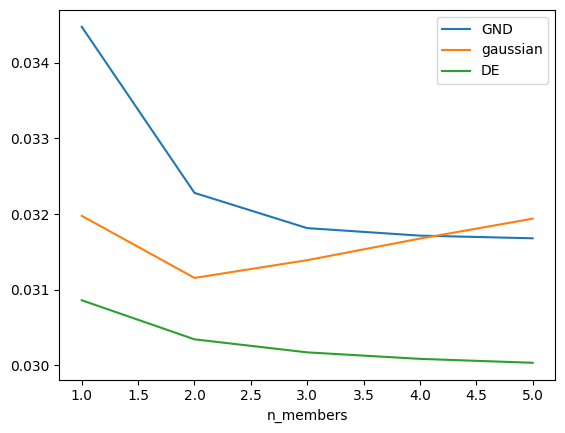

In [20]:
METRIC = "mse"
model_name = f'pog_model_0_{MEMBERS_LL.GND.value}_{1.0}_{16}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                   label=MEMBERS_LL.GND.value, 
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
model_name = f'pog_model_0_{MEMBERS_LL.gaussian.value}_{1.0}_{16}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot(label=MEMBERS_LL.gaussian.value
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(label="DE"
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
plt.legend()
plt.show()

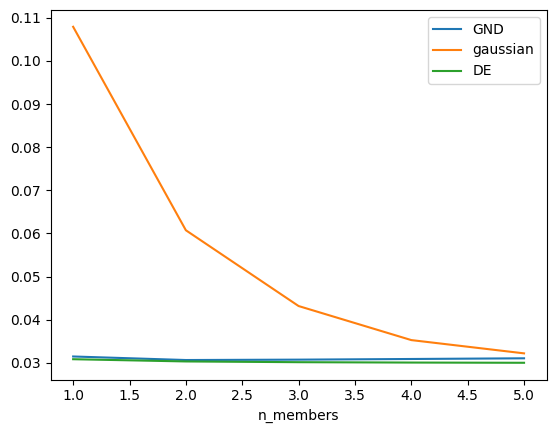

In [34]:
METRIC = "mse"
model_name = f'pog_model_0_{MEMBERS_LL.GND.value}_{0.5}_{2}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                   label=MEMBERS_LL.GND.value, 
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
model_name = f'pog_model_0_{MEMBERS_LL.gaussian.value}_{0.5}_{2}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot(label=MEMBERS_LL.gaussian.value
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(label="DE"
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
plt.legend()
plt.show()

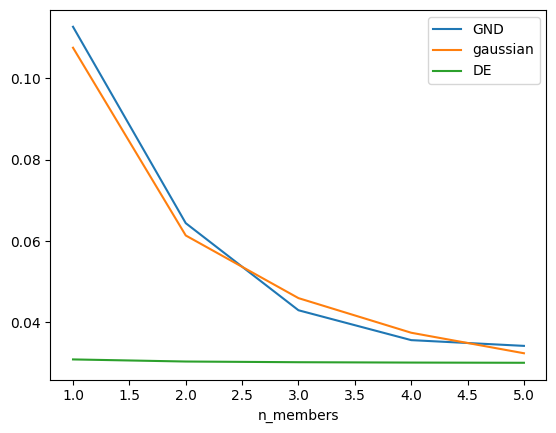

In [22]:
METRIC = "mse"
model_name = f'pog_model_0_{MEMBERS_LL.GND.value}_{0.5}_{8}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                   label=MEMBERS_LL.GND.value, 
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
model_name = f'pog_model_0_{MEMBERS_LL.gaussian.value}_{0.5}_{8}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot(label=MEMBERS_LL.gaussian.value
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(label="DE"
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
plt.legend()
plt.show()

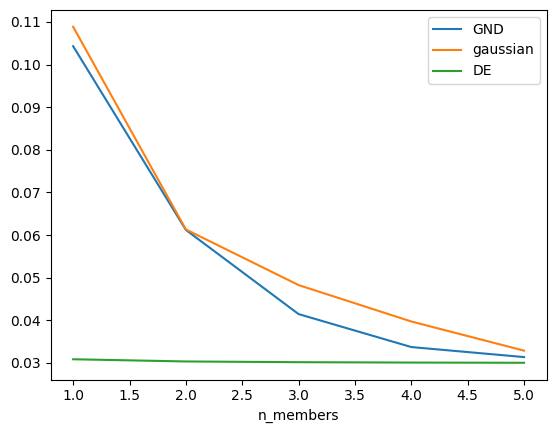

In [23]:
METRIC = "mse"
model_name = f'pog_model_0_{MEMBERS_LL.GND.value}_{0.5}_{16}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot( 
                                                   label=MEMBERS_LL.GND.value, 
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
model_name = f'pog_model_0_{MEMBERS_LL.gaussian.value}_{0.5}_{16}'
metrics_df[METRIC]["mean"].loc[model_name, :].plot(label=MEMBERS_LL.gaussian.value
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
metrics_df[METRIC]["mean"].loc['ens_model_0', :].plot(label="DE"
                                                   # color="red", 
                                                   # alpha=alpha_plot[i]
                                                    )
plt.legend()
plt.show()

#### compare predictive distributions

In [24]:
models = ["pog_model_0_gaussian_1.0_2", "pog_model_0_GND_1.0_2"]

In [25]:
for model_name in models:
    print(model_name)
    if "pog" in model_name:
        model_type = pog_model
        state = restore_checkpoint(f'dynNN_results/{model_name}', 1)
    elif "ens" in model_name:
        model_type = ens_model
        state = restore_checkpoint(f'dynNN_results/{model_name}', 1)["0"]

    pred_fun = partial(
        model_type.apply,
        {"params": state['params'], **state['model_state']},
        train=False, return_ens_preds=True,
        method=model_type.pred
    )
    _, (locs, scales) = jax.vmap(
        pred_fun, out_axes=(0, 1), in_axes=(0,), axis_name="batch"
    )(jnp.array(X_test))
    
    for i in range(5):
        print(i)
        loc, scale = calculate_pog_loc_scale(locs[(i,), :, 0], scales[(i,), :, 0])
        errors = jax.vmap(mse)(loc, jnp.array(y_test))
        loc_de, scale_de = calculate_ens_loc_scale(locs[(i,), :, 0], scales[(i,), :, 0], 1)
        errors_de = jax.vmap(mse)(loc_de, jnp.array(y_test))
        print(errors.mean())
        print(errors_de.mean())

pog_model_0_gaussian_1.0_2
0
0.030165693
0.030165693
1
0.032101937
0.032101937
2
0.035763014
0.035763014
3
0.031322356
0.031322356
4
0.030530985
0.030530985
pog_model_0_GND_1.0_2
0
0.029811466
0.029811462
1
0.030464621
0.03046462
2
0.029827299
0.029827295
3
0.030753948
0.030753948
4
0.030005338
0.030005338


In [26]:
model_type = pog_model
state = restore_checkpoint(f'dynNN_results/pog_model_0_gaussian_1.0_2', 1)

pred_fun = partial(
    model_type.apply,
    {"params": state['params'], **state['model_state']},
    train=False, return_ens_preds=True,
    method=model_type.pred
)
_, (locs, scales) = jax.vmap(
    pred_fun, out_axes=(0, 1), in_axes=(0,), axis_name="batch"
)(jnp.array(X_test))

In [27]:
locs[0, :, :]

DeviceArray([[-0.46521682],
             [ 1.4058795 ],
             [-0.38147682],
             [-0.28817928],
             [-0.56917024],
             [-0.5262661 ],
             [ 1.2126133 ],
             [-0.526917  ],
             [ 1.0717645 ],
             [-0.23807766],
             [ 1.2263699 ],
             [-0.4403892 ],
             [ 1.4484799 ],
             [-1.1748601 ],
             [ 1.4670346 ],
             [ 1.449084  ],
             [ 1.4392226 ],
             [-0.57787675],
             [ 0.9184775 ],
             [-0.28645152],
             [-0.40576172],
             [-0.59728694],
             [-0.42310727],
             [ 1.4112663 ],
             [-0.50812197],
             [-0.4160838 ],
             [-0.52276456],
             [-0.71206516],
             [ 1.2472372 ],
             [-0.5980631 ],
             [-1.2134528 ],
             [ 1.124541  ],
             [-0.8780004 ],
             [-1.5973082 ],
             [ 0.9118791 ],
             [-0.366

In [28]:
scales[0, :, :]

DeviceArray([[0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
             [0.5732112],
            

In [29]:
model_type = pog_model
state = restore_checkpoint(f'dynNN_results/pog_model_0_GND_1.0_2', 1)

pred_fun = partial(
    model_type.apply,
    {"params": state['params'], **state['model_state']},
    train=False, return_ens_preds=True,
    method=model_type.pred
)
_, (locs_gnd, scales_gnd) = jax.vmap(
    pred_fun, out_axes=(0, 1), in_axes=(0,), axis_name="batch"
)(jnp.array(X_test))

In [30]:
locs_gnd[0, :, :]

DeviceArray([[-0.4766881 ],
             [ 1.4007488 ],
             [-0.3671754 ],
             [-0.272146  ],
             [-0.5731556 ],
             [-0.5555912 ],
             [ 1.2129302 ],
             [-0.55624986],
             [ 1.0733155 ],
             [-0.2180244 ],
             [ 1.2265655 ],
             [-0.43645895],
             [ 1.4442033 ],
             [-1.166947  ],
             [ 1.4635013 ],
             [ 1.470304  ],
             [ 1.4345742 ],
             [-0.5805649 ],
             [ 0.92124414],
             [-0.27038616],
             [-0.39913037],
             [-0.5997757 ],
             [-0.42987874],
             [ 1.4064769 ],
             [-0.5208473 ],
             [-0.41742858],
             [-0.53591734],
             [-0.71334815],
             [ 1.2472519 ],
             [-0.6006045 ],
             [-1.206051  ],
             [ 1.1256288 ],
             [-0.86626816],
             [-1.6016217 ],
             [ 0.91470253],
             [-0.351

In [31]:
scales_gnd[1, :, :]

DeviceArray([[0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
             [0.52647907],
 

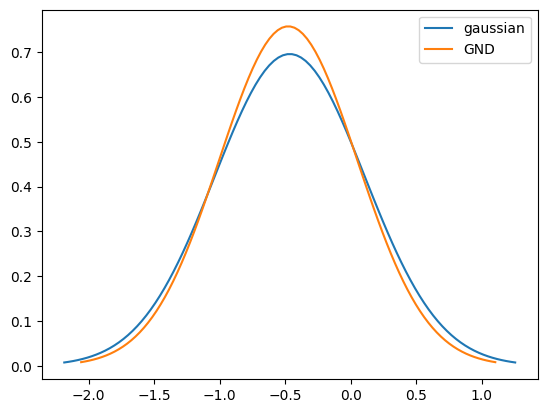

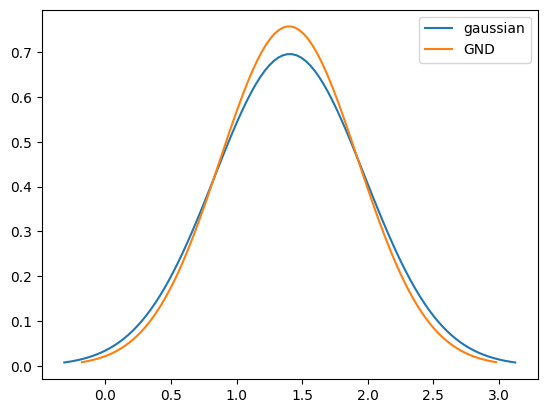

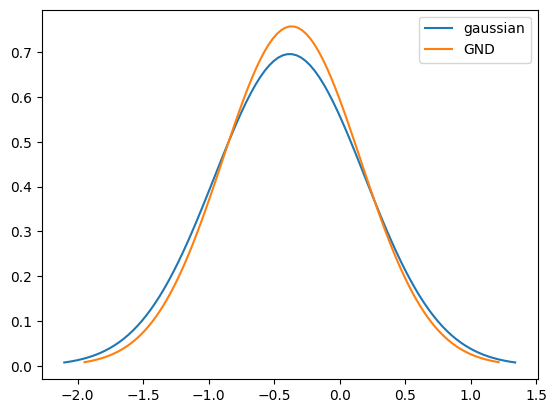

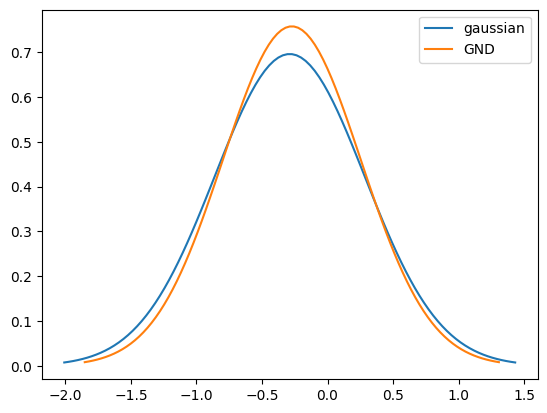

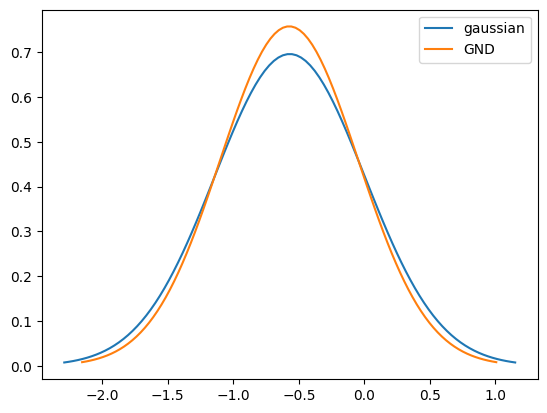

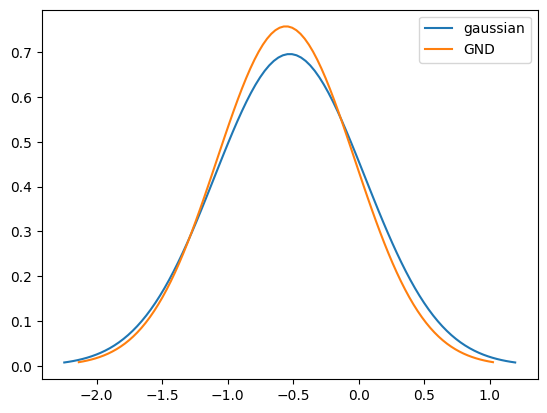

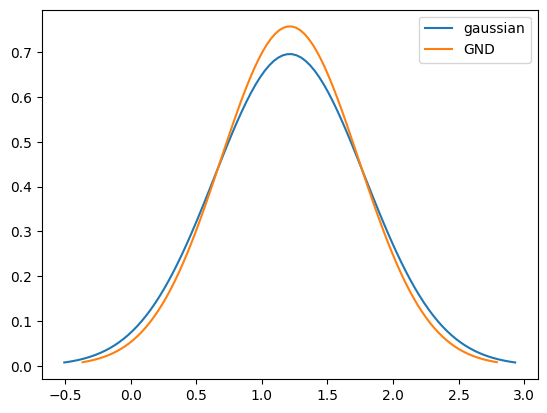

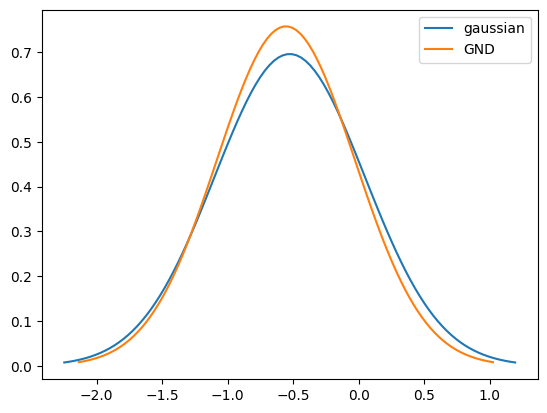

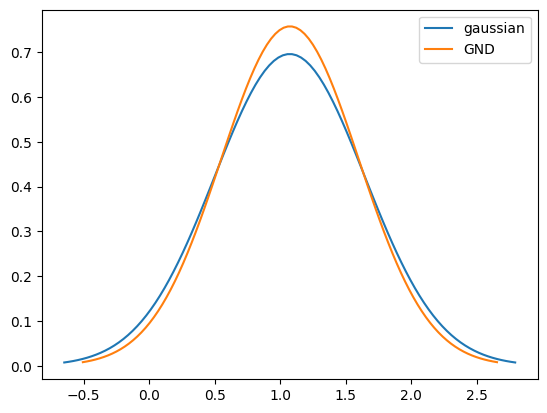

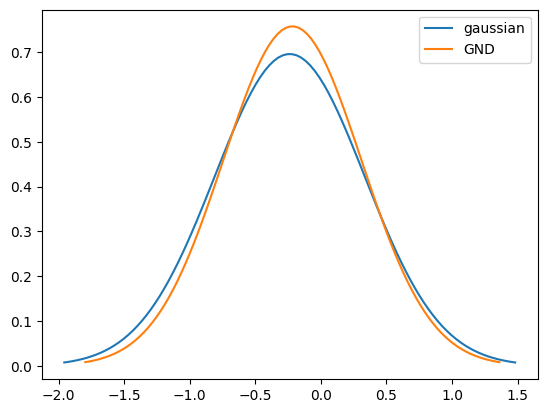

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

for i in range(10):
    mu = locs[0, i, :]
    sigma = scales[0, i, :]
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label="gaussian")
    
    mu = locs_gnd[0, i, :]
    sigma = scales_gnd[0, i, :]
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label="GND")
    
    plt.legend()
    plt.show()

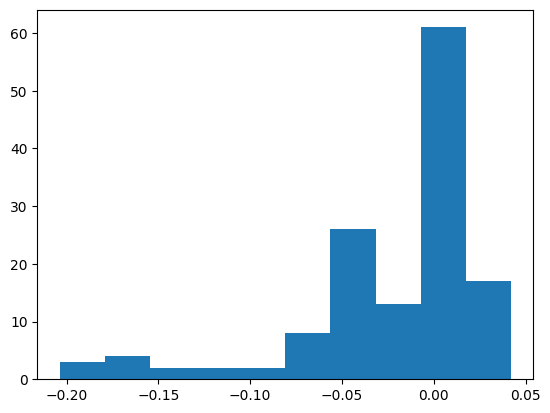

In [33]:
plt.hist(np.array(locs[2, :, :] - locs_gnd[2, :, :]), bins=10);